In [ ]:
!pip install ccxt
!pip install pandas-ta
!pip install Backtesting
!pip install tensorflow==2.15.0
!pip install tensorflow_probability==0.23.0
!pip install git+https://github.com/tensorflow/docs
!pip install optuna
!pip install optuna-dashboard
!pip uninstall bokeh
!pip install bokeh==3.1.0

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
tfd = tfp.distributions
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from keras.regularizers import l2
from keras.layers import LSTM, Dropout, Dense, BatchNormalization, LayerNormalization, Input, Flatten
%load_ext tensorboard

import numpy as np
import pandas as pd
import pandas_ta as ta
from pandas_ta import ema,bbands,rsi
from collections import deque

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import gaussian_kde, norm
import seaborn as sns

import optuna
import threading
from optuna_dashboard import run_server
import backtesting as bt
from backtesting import Backtest, Strategy

import ccxt
import os
import datetime
import time
import IPython
import IPython.display
from google.colab import files, drive, output


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['axes.grid'] = False

#Fetch the data

## Fetch functions

In [3]:
def fetch_ohlcv_multiple(exchange, symbol, timeframe, start_timestamp, end_timestamp, limit=300):
    ohlcv_list = []
    current_timestamp = start_timestamp
    while current_timestamp < end_timestamp:
        # Calculate the end timestamp for this request
        next_timestamp = min(current_timestamp + limit * 60 * 1000, end_timestamp)

        # Fetch OHLCV data
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=current_timestamp, limit=limit)

        # Append the fetched data to the list
        ohlcv_list.extend(ohlcv)

        # Update the current timestamp for the next request
        current_timestamp = ohlcv[-1][0] + (ohlcv[-1][0] - ohlcv[-2][0])

        time.sleep(1)

    return ohlcv_list

def fetch_ohlcv_hourly(exchange, symbol, days=100):
    # Set the timeframe to 1 hour
    timeframe = '1h'

    # Calculate start and end timestamps
    end_timestamp = datetime.datetime.now().timestamp() * 1000
    start_timestamp = end_timestamp - (days * 24 * 60 * 60 * 1000)

    # Fetch OHLCV data (possibly in multiple requests)
    ohlcv = fetch_ohlcv_multiple(exchange, symbol, timeframe, start_timestamp, end_timestamp)

    # Convert the data to a Pandas DataFrame
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

    # Convert timestamp to a readable date format
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', origin='unix')

    # Set timestamp as the index
    df.set_index('timestamp', inplace=True)

    return df

def fetch_ohlcv_5mins(exchange, symbol, days=100):
    # Set the timeframe to 5minutes
    timeframe = '5m'
    limit = 300

    # Calculate start and end timestamps
    end_timestamp = datetime.datetime.now().timestamp() * 1000
    start_timestamp = end_timestamp - (days * 24 * 60 * 60 * 1000)

    # Fetch OHLCV data (possibly in multiple requests)
    ohlcv = fetch_ohlcv_multiple(exchange, symbol, timeframe, start_timestamp, end_timestamp, limit)

    # Convert the data to a Pandas DataFrame
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

    # Convert timestamp to a readable date format
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', origin='unix')

    # Set timestamp as the index
    df.set_index('timestamp', inplace=True)

    return df

def fetch_ohlcv_15mins(exchange, symbol, days=100):
    # Set the timeframe to 5minutes
    timeframe = '15m'
    limit = 300

    # Calculate start and end timestamps
    end_timestamp = datetime.datetime.now().timestamp() * 1000
    start_timestamp = end_timestamp - (days * 24 * 60 * 60 * 1000)

    # Fetch OHLCV data (possibly in multiple requests)
    ohlcv = fetch_ohlcv_multiple(exchange, symbol, timeframe, start_timestamp, end_timestamp, limit)

    # Convert the data to a Pandas DataFrame
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

    # Convert timestamp to a readable date format
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', origin='unix')

    # Set timestamp as the index
    df.set_index('timestamp', inplace=True)

    return df

def getData(loadFromLocalStorage,csv_path):
  df_orig = []
  if(loadFromLocalStorage):
    df_orig = pd.read_csv(csv_path)
    # Set timestamp as the index
    df_orig.set_index('timestamp', inplace=True)
  else:
    exchange=ccxt.coinbase()
    symbol = "XRP/USDT"
    df_orig = fetch_ohlcv_hourly(exchange,symbol,500)
    df_orig.to_csv(csv_path,index=True)

  return df_orig

## Fetch code

In [96]:
colabPath = '/content/drive/MyDrive/Colab Notebooks/MachineLearningPython/StockPrediction'
csv_path=os.path.join(colabPath, 'datasets/BTC_ohlcv_hourly.csv')

In [98]:
drive.mount('/content/drive')
loadFromLocalStorage = True

df_orig = getData(loadFromLocalStorage,csv_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preprocessing

##Preprocessing functions

In [7]:
def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower

## Dataset

features  = ['Open','High','Low','Close','LogRet','RSI','EMA_10','EMA_50','MACD','ATR','Stochastic_Oscillator','BB_upper','BB_lower','BB_width','Volume_MA10','VWAP','Prev_Close_1','Prev_Close_2','Close_to_High','Close_to_Low']

target = ['Delta_Close_4']

In [99]:
# Get the Dataset from the original df
df = df_orig.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
})

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,28796.0,40925.241883,18208.954435,15644.170000,26049.20000,38600.895000,57649.130000,99378.730000
High,28796.0,41081.656555,18282.506704,15761.300000,26094.21500,38779.155000,57924.925000,99750.000000
Low,28796.0,40762.178694,18132.609488,15477.170000,26002.88250,38441.090000,57398.927500,99002.210000
Close,28796.0,40926.460426,18211.762699,15653.240000,26049.27250,38602.245000,57651.990000,99373.280000
Volume,28796.0,34.893370,44.534851,0.009553,9.82098,20.393619,42.505656,1023.329662


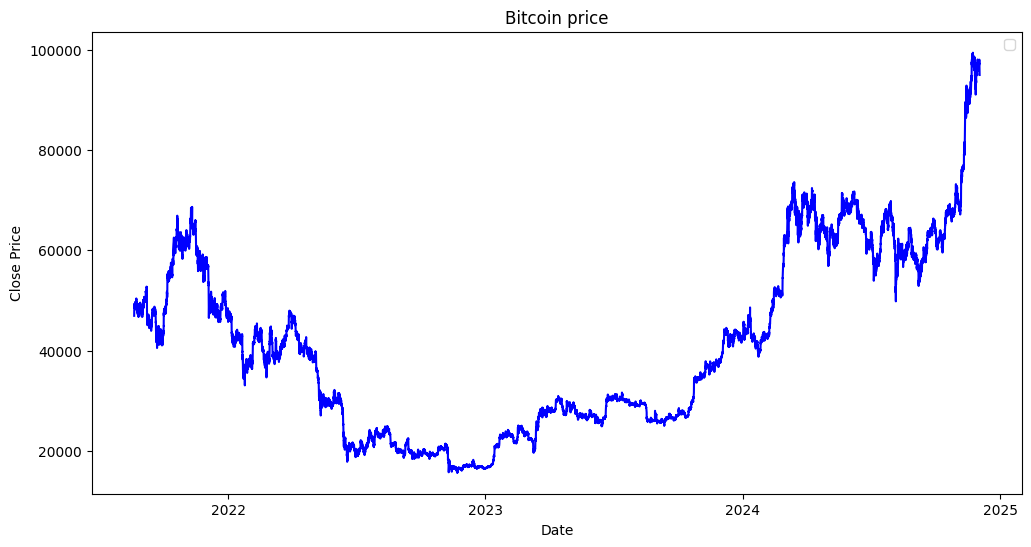

In [100]:
# Plot
# Convert the index to datetime if it's not already
df.index = pd.to_datetime(df.index)
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], color='blue')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Bitcoin price')
plt.legend()
# Format the x-axis to show years only
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

plt.show()

In [101]:
future_steps = 4  # 1 hour ahead in 15-min intervals
# Price derived features
close=df.Close
low=df.Low
high=df.High
ema10 = ema(df.Close, length = 10)  # Fast
ema50 = ema(df.Close, length = 50) # Medium
ema12 = ema(df.Close, length = 12) # Medium
ema26 = ema(df.Close, length = 26) # Medium
upper, lower = BBANDS(df[['High','Low','Close']], 20, 2)

df['LogRet'] = np.log(df.Close / df.Close.shift(1))

df['RSI'] = rsi(df.Close, length = 14)
# Moving averages
# Price-derived features
df['EMA_10'] = (close - ema10)
df['EMA_50'] = (close - ema50)
df['MACD'] = (ema12-ema26)

# Volatility and Trend Indicators
df['ATR'] = ta.atr(high, low, close, length=14)
df['Stochastic_Oscillator'] = (close - low.rolling(window=14).min()) / (high.rolling(window=14).max() - low.rolling(window=14).min())
df['BB_upper'] = (upper - close)
df['BB_lower'] = (close - lower)
df['BB_width'] = (upper - lower)

# Volume-based Features
df['Volume_MA10'] = df['Volume'].rolling(window=10).mean()
df['VWAP'] = (df['Volume'] * (high + low + close) / 3).cumsum() / df['Volume'].cumsum()

# Lagged Features
df['Prev_Close_1'] = close.shift(4)  # 1 hour ago
df['Prev_Close_2'] = close.shift(8)  # 2 hours ago

# Close-to-High and Close-to-Low Ratios
df['Close_to_High'] = close / high
df['Close_to_Low'] = close / low


# Predicted value
df['Delta_Close_4'] = close.shift(-future_steps) - close
df = df.drop(columns=['Volume'])
#Split data to test and test data
df.dropna(inplace = True)

df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Open,28743.0,40904.089648,18211.293552,15644.170000,26044.565000,38555.570000,57676.625000,99378.730000
High,28743.0,41060.419275,18284.926899,15761.300000,26086.600000,38741.910000,57947.725000,99750.000000
Low,28743.0,40741.155022,18135.040882,15477.170000,25995.585000,38387.890000,57423.595000,99002.210000
Close,28743.0,40905.302096,18214.235153,15653.240000,26044.065000,38551.590000,57676.340000,99373.280000
LogRet,28743.0,0.000023,0.005881,-0.073103,-0.002195,0.000042,0.002338,0.062791
RSI,28743.0,50.498265,12.158035,6.335212,42.857186,50.431656,57.937056,92.658687
EMA_10,28743.0,7.480616,366.621110,-4347.570997,-106.862638,3.673584,123.339837,3367.516199
EMA_50,28743.0,40.868545,896.363559,-7619.742568,-302.664300,12.903694,398.518326,6976.913503
MACD,28743.0,11.691958,293.341088,-2356.394886,-96.725415,4.194731,123.292855,2172.921324
ATR,28743.0,320.003584,212.317532,17.903392,156.113644,276.431795,441.280324,1630.041385


In [ ]:
df.head()

,Open,High,Low,Close,LogRet,RSI,EMA_10,EMA_50,MACD,ATR,...,BB_upper,BB_lower,BB_width,Volume_MA10,VWAP,Prev_Close_1,Prev_Close_2,Close_to_High,Close_to_Low,Delta_Close_4
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-08-22 12:00:00,49138.32,49310.19,48833.60,48874.74,-0.004970,47.068954,-197.687357,-18.763200,44.205293,350.471229,...,632.398761,159.553428,791.952188,7.558309,48909.950503,49063.45,49118.69,0.991169,1.000842,-263.38
2021-08-22 13:00:00,48869.28,49000.00,48671.66,48872.28,-0.000050,47.015996,-163.756929,-20.390918,24.837428,348.850574,...,534.575041,133.572375,668.147416,9.224695,48908.760607,49213.82,49160.87,0.997393,1.004122,-189.24
2021-08-22 14:00:00,48844.41,48954.58,48165.42,48207.49,-0.013696,35.418557,-677.902033,-658.311078,-43.651555,381.036172,...,1203.929266,-424.433401,779.495865,12.409834,48893.072959,49152.96,49188.77,0.984739,1.000873,185.56
2021-08-22 15:00:00,48182.09,48532.70,48050.00,48523.77,0.006539,42.664753,-295.872572,-328.618094,-71.583246,388.455179,...,948.520163,22.933163,971.453326,14.142496,48881.620902,49118.25,49190.19,0.999816,1.009860,104.48
2021-08-22 16:00:00,48511.11,48830.18,48369.97,48611.36,0.001803,44.521259,-170.413014,-231.576012,-85.664051,393.683460,...,870.179571,159.503571,1029.683143,14.653327,48878.693621,48874.74,49063.45,0.995519,1.004990,-235.14


##Split and scale the data

In [102]:
count_df = len(df.columns)

In [103]:
df.reset_index(inplace = True)
# Define split indices for train, validation, and test
train_idx = int(len(df) * 0.7)
val_idx = int(len(df) * 0.9)

backtest_df = df[val_idx:]
backtest_df.reset_index(inplace = True)
backtest_df = backtest_df.drop(columns=['index'])
backtest_df.set_index('timestamp', inplace=True)

df = df.drop(columns=['timestamp'])

df.head()

,Open,High,Low,Close,LogRet,RSI,EMA_10,EMA_50,MACD,ATR,...,BB_upper,BB_lower,BB_width,Volume_MA10,VWAP,Prev_Close_1,Prev_Close_2,Close_to_High,Close_to_Low,Delta_Close_4
0,49138.32,49310.19,48833.60,48874.74,-0.004970,47.068954,-197.687357,-18.763200,44.205293,350.471229,...,632.398761,159.553428,791.952188,7.558309,48909.950503,49063.45,49118.69,0.991169,1.000842,-263.38
1,48869.28,49000.00,48671.66,48872.28,-0.000050,47.015996,-163.756929,-20.390918,24.837428,348.850574,...,534.575041,133.572375,668.147416,9.224695,48908.760607,49213.82,49160.87,0.997393,1.004122,-189.24
2,48844.41,48954.58,48165.42,48207.49,-0.013696,35.418557,-677.902033,-658.311078,-43.651555,381.036172,...,1203.929266,-424.433401,779.495865,12.409834,48893.072959,49152.96,49188.77,0.984739,1.000873,185.56
3,48182.09,48532.70,48050.00,48523.77,0.006539,42.664753,-295.872572,-328.618094,-71.583246,388.455179,...,948.520163,22.933163,971.453326,14.142496,48881.620902,49118.25,49190.19,0.999816,1.009860,104.48
4,48511.11,48830.18,48369.97,48611.36,0.001803,44.521259,-170.413014,-231.576012,-85.664051,393.683460,...,870.179571,159.503571,1029.683143,14.653327,48878.693621,48874.74,49063.45,0.995519,1.004990,-235.14


In [ ]:
backtest_df.head()

,Open,High,Low,Close,LogRet,RSI,EMA_10,EMA_50,MACD,ATR,...,BB_upper,BB_lower,BB_width,Volume_MA10,VWAP,Prev_Close_1,Prev_Close_2,Close_to_High,Close_to_Low,Delta_Close_4
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-08-04 12:00:00,60887.98,61094.61,60805.42,61094.61,0.003696,51.345453,297.072192,-569.036953,-212.931208,409.865364,...,-76.015836,829.011164,752.995328,6.852191,33943.989357,60561.09,60560.67,1.000000,1.004756,-2429.52
2024-08-04 13:00:00,61018.74,61018.74,60830.26,60831.65,-0.004313,46.048478,27.909975,-799.369621,-194.332311,399.471410,...,214.410006,571.356672,785.766678,6.041849,33944.094478,60710.95,60805.40,0.996934,1.000023,-2960.82
2024-08-04 14:00:00,60835.63,60873.48,59330.49,59564.33,-0.021053,29.990498,-1014.062748,-1985.642969,-278.642665,481.151309,...,1566.764437,-560.756897,1006.007540,11.094990,33945.673269,60818.04,60814.17,0.978494,1.003941,-780.08
2024-08-04 15:00:00,59597.83,59601.48,58965.67,59078.82,-0.008184,26.218435,-1226.923157,-2374.245010,-380.252512,492.198358,...,2293.063607,-700.102393,1592.961214,15.088971,33946.898469,60869.25,60363.37,0.991231,1.001919,158.79
2024-08-04 16:00:00,59102.25,59310.07,58618.52,58665.09,-0.007028,23.505338,-1342.352583,-2678.642657,-488.532108,506.437761,...,2937.510906,-728.798761,2208.712145,18.422987,33947.862556,61094.61,60561.09,0.989125,1.000794,491.11


(20120, 21)
(5748, 21)
(2875, 21)


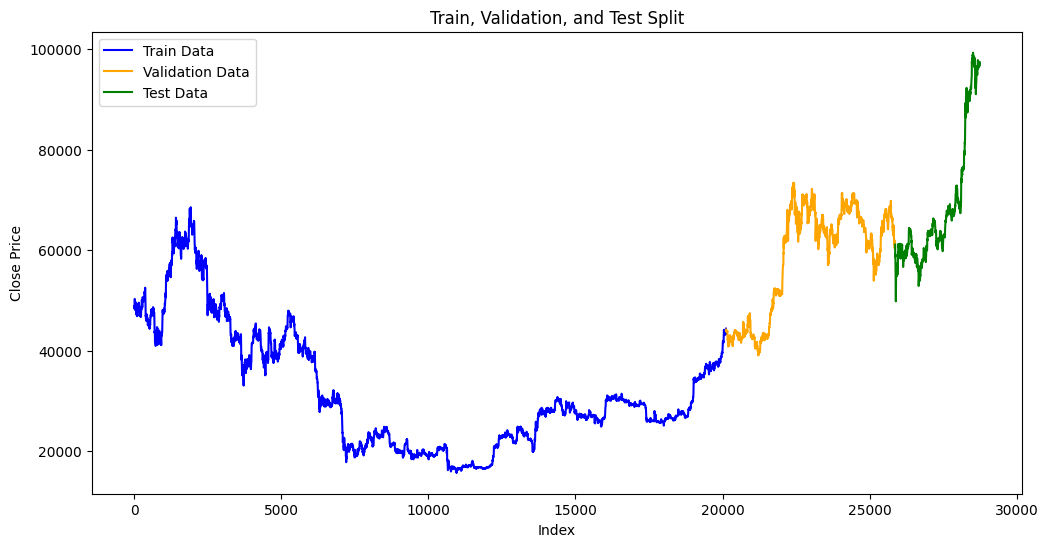

In [104]:
# Split data
train_data = df[:train_idx]
val_data = df[train_idx:val_idx]
test_data = df[val_idx:]

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_data[::4]['Close'], label='Train Data', color='blue')
plt.plot(val_data[::4]['Close'], label='Validation Data', color='orange')
plt.plot(test_data[::4]['Close'], label='Test Data', color='green')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Train, Validation, and Test Split')
plt.legend()
plt.show()

In [105]:
# Scalers
df_columns_to_scale = ['Open','High','Low','Close','LogRet','RSI','EMA_10','EMA_50','MACD','ATR','Stochastic_Oscillator','BB_upper','BB_lower','BB_width','Volume_MA10','VWAP','Prev_Close_1','Prev_Close_2','Close_to_High','Close_to_Low']
sc = MinMaxScaler(feature_range=(0,1))
sc_y = StandardScaler()

In [106]:
train_df = train_data.copy()
val_df = val_data.copy()
test_df = test_data.copy()

train_df[df_columns_to_scale] = sc.fit_transform(train_df[df_columns_to_scale])
train_df['Delta_Close_4'] = sc_y.fit_transform(train_df[['Delta_Close_4']])
scaled_train_df = train_df.iloc[:, 0:count_df].values

val_df[df_columns_to_scale] = sc.transform(val_df[df_columns_to_scale])
val_df['Delta_Close_4'] = sc_y.transform(val_df[['Delta_Close_4']])
scaled_val_df = val_df.iloc[:, 0:count_df].values

test_df[df_columns_to_scale] = sc.transform(test_df[df_columns_to_scale])
test_df['Delta_Close_4'] = sc_y.transform(test_df[['Delta_Close_4']])
scaled_test_df = test_df.iloc[:, 0:count_df].values

train_df.describe().transpose()



,count,mean,std,min,25%,50%,75%,max
Open,20120.0,0.308228,0.227116,0.000000,0.129517,0.244787,0.464887,1.000000
High,20120.0,0.306883,0.227182,0.000000,0.129100,0.244155,0.463360,1.000000
Low,20120.0,0.309015,0.225926,0.000000,0.131084,0.246049,0.464635,1.000000
Close,20120.0,0.308101,0.227150,0.000000,0.129345,0.244692,0.464829,1.000000
LogRet,20120.0,0.537903,0.044316,0.000000,0.521878,0.538200,0.554473,1.000000
RSI,20120.0,0.507034,0.141405,0.000000,0.419061,0.505377,0.592440,1.000000
EMA_10,20120.0,0.652320,0.045402,0.000000,0.639247,0.652567,0.666137,1.000000
EMA_50,20120.0,0.633527,0.063009,0.000000,0.611928,0.633794,0.658172,1.000000
MACD,20120.0,0.649601,0.067357,0.000000,0.627051,0.650102,0.674016,1.000000
ATR,20120.0,0.167000,0.122553,0.000000,0.077046,0.125928,0.235186,1.000000


In [ ]:
val_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,5748.0,0.806614,0.196942,0.436362,0.575503,0.889150,0.968293,1.092965
High,5748.0,0.804418,0.196807,0.434343,0.574200,0.887420,0.966232,1.089748
Low,5748.0,0.805785,0.196116,0.435470,0.574655,0.886733,0.967592,1.089738
Close,5748.0,0.806630,0.196963,0.436156,0.575669,0.889116,0.968162,1.093189
LogRet,5748.0,0.538352,0.040364,0.192038,0.521425,0.538417,0.556377,0.836205
RSI,5748.0,0.518046,0.138942,0.101281,0.427445,0.515911,0.603870,0.951639
EMA_10,5748.0,0.654449,0.069084,0.035163,0.627300,0.655219,0.682660,1.017697
EMA_50,5748.0,0.640631,0.092870,0.117218,0.594578,0.638618,0.688766,1.102116
MACD,5748.0,0.656025,0.098725,0.307952,0.608858,0.655281,0.705074,1.025344
ATR,5748.0,0.293188,0.143618,0.064591,0.186736,0.270126,0.360908,1.115617


In [ ]:
test_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,2875.0,0.995193,0.238380,0.644458,0.830607,0.902698,1.019980,1.579917
High,2875.0,0.992813,0.238220,0.672000,0.828970,0.899489,1.020091,1.576883
Low,2875.0,0.994058,0.237597,0.633218,0.829432,0.901962,1.020282,1.576607
Close,2875.0,0.995429,0.238618,0.644648,0.830324,0.902708,1.020108,1.579927
LogRet,2875.0,0.539115,0.041480,0.284410,0.521582,0.538497,0.556461,0.854817
RSI,2875.0,0.530660,0.138604,0.091294,0.447796,0.534682,0.615169,0.966863
EMA_10,2875.0,0.660986,0.078971,0.157910,0.624772,0.658724,0.691905,1.157892
EMA_50,2875.0,0.659558,0.111760,-0.014114,0.597609,0.658205,0.713098,1.227580
MACD,2875.0,0.674159,0.117076,0.010572,0.613147,0.670744,0.732123,1.249614
ATR,2875.0,0.335176,0.164473,0.090517,0.235675,0.292110,0.389418,1.064154


In [107]:
# Prepare the data for LSTM layers
# Define the number of 15-minute intervals
backcandles = 32  # 8 hours of 15-min intervals
label_index = train_df.columns.get_loc('Delta_Close_4')
# Update the feature preparation
X_train = np.array([scaled_train_df[i-backcandles:i, : label_index].copy() for i in range(backcandles, len(scaled_train_df)-future_steps+1)])
y_train = np.array(scaled_train_df[backcandles-1:-future_steps, label_index])
Y_train = np.reshape(y_train, (len(y_train), 1))

X_validation = np.array([scaled_val_df[i-backcandles:i, : label_index].copy() for i in range(backcandles, len(scaled_val_df)-future_steps+1)])
yi_val = np.array(scaled_val_df[backcandles-1:-future_steps,  label_index])
Y_validation = np.reshape(yi_val, (len(yi_val), 1))

X_test = np.array([scaled_test_df[i-backcandles:i, : label_index].copy() for i in range(backcandles, len(scaled_test_df)-future_steps+1)])
yi_test = np.array(scaled_test_df[backcandles-1:-future_steps,  label_index])
Y_test = np.reshape(yi_test, (len(yi_test), 1))

print(f"X_train shape: {X_train.shape}")
print(f"X_validation shape: {X_validation.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_validation shape: {Y_validation.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (20085, 32, 20)
X_validation shape: (5713, 32, 20)
X_test shape: (2840, 32, 20)
Y_train shape: (20085, 1)
Y_validation shape: (5713, 1)
Y_test shape: (2840, 1)


In [ ]:
print(Y_train[-1])
print(scaled_train_df[-5,train_df.columns.get_loc('Delta_Close_4')])

[0.5120774]
0.5120773961011067


#Creating and training the model

In [138]:
local_directory  = os.path.join(colabPath, "mdnlstm_dcp/model_v2.keras")
checkpoint_path = os.path.join(colabPath, "mdnlstm_dcp/training_BTC_2_dc4/best_checkpoint.weights.h5")

## Calculate step sizes

In [139]:
BATCH_SIZE = 64
N_TRAIN = X_train.shape[0]
EPOCHS = 50

In [140]:
metrics=[keras.metrics.MeanAbsoluteError(),keras.metrics.RootMeanSquaredError(),keras.metrics.R2Score()]

##Funtions

In [141]:
def get_callbacks(checkpoint_path):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=10,
                                                    mode='min',restore_best_weights=True)

  # Create a callback that saves the model's weights
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_best_only = True,
                                                  save_weights_only=True,
                                                  monitor='val_loss',
                                                  mode='min')

  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

  return [early_stopping, cp_callback, reduce_lr]

In [142]:
def compile_and_fit(layers, loss_fn, optimizer, metrics, checkpoint_path):
  model = layers
  model.compile(loss= loss_fn,
                optimizer= optimizer,
                metrics= metrics)
  model.summary()
  history = model.fit(X_train, Y_train, epochs=EPOCHS, validation_data=(X_validation, Y_validation),callbacks=get_callbacks(checkpoint_path), batch_size=BATCH_SIZE)

  return model,history

def compile_and_load_latest_weights(model, loss_fn, optimizer, metrics, checkpoint_path):
  model.compile(loss=loss_fn,
                optimizer=optimizer,
                metrics=metrics)
  model.summary()
  # Load the latest weight for the model.
  model.load_weights(checkpoint_path)

  return model

def plot_model_history(history, metric):
  plotter = tfdocs.plots.HistoryPlotter(metric = metric, smoothing_std=10)
  plotter.plot(history.history[metric])
  a = plt.xscale('log')
  plt.xlim([5, max(plt.xlim())])
  plt.ylim([0.5, 0.7])
  plt.xlabel("Epochs [Log Scale]")

def save_model(model, filepath):
  model.save(filepath)

def load_model(filepath):
  # Load the model if available
  model = tf.keras.models.load_model(filepath)
  return model

## Load trained model

In [113]:
model = tf.keras.models.load_model(local_directory,safe_mode=False)

# Show the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                3280      
                                                                 
 layer_normalization (Layer  (None, 20)                40        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 9)                 189       
                                                                 
 dropout_1 (Dropout)         (None, 9)                 0         
                                                                 
 mixture_normal (MixtureNor  ((None, 1),               0         
 mal)                         (None, 1))                

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:159: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         lambda t: MixtureNormal.new(  # pylint: disable=g-long-lambda
            t, num_components, event_shape, validate_args),

  config_arr = [serialize_keras_object(x) for x in obj]


## Layers of the model

In [144]:
num_components = 3
event_shape = [1]
params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)

layers = tf.keras.Sequential([
    LSTM(25, return_sequences=True, activation="relu", input_shape=X_train.shape[1:], kernel_regularizer=l2(0.001),recurrent_dropout=0.1),
    LayerNormalization(),
    Dropout(0.2),

    LSTM(20, return_sequences=False,activation="relu", kernel_regularizer=l2(0.001),recurrent_dropout=0.1),
    LayerNormalization(),
    Dropout(0.2),

    Dense(params_size, activation=None),
    Dropout(0.1),

    tfp.layers.MixtureNormal(num_components, event_shape)
])

# loss function for distributions
loss = lambda y, rv_y: -rv_y.log_prob(y)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.004, decay_steps=1000, decay_rate=0.94, staircase=True)

opt = tf.keras.optimizers.Adam(lr_schedule)

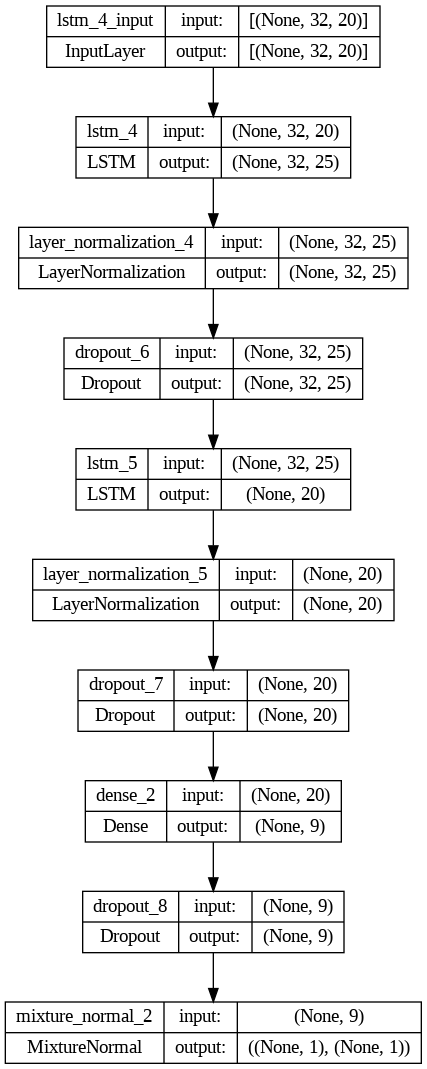

In [145]:
tf.keras.utils.plot_model(layers, show_shapes=True)

## Load weights from checkpoints

In [ ]:
model = compile_and_load_latest_weights(layers, loss, opt, metrics, checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                3280      
                                                                 
 layer_normalization (Layer  (None, 20)                40        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 9)                 189       
                                                                 
 dropout_1 (Dropout)         (None, 9)                 0         
                                                                 
 mixture_normal (MixtureNor  ((None, 1),               0         
 mal)                         (None, 1))                

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:159: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         lambda t: MixtureNormal.new(  # pylint: disable=g-long-lambda
            t, num_components, event_shape, validate_args),

  config_arr = [serialize_keras_object(x) for x in obj]


##Train model

In [146]:
model,history = compile_and_fit(layers, loss, opt,metrics, checkpoint_path)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 32, 25)            4600      
                                                                 
 layer_normalization_4 (Lay  (None, 32, 25)            50        
 erNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 32, 25)            0         
                                                                 
 lstm_5 (LSTM)               (None, 20)                3680      
                                                                 
 layer_normalization_5 (Lay  (None, 20)                40        
 erNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 20)               

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:159: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         lambda t: MixtureNormal.new(  # pylint: disable=g-long-lambda
            t, num_components, event_shape, validate_args),

  config_arr = [serialize_keras_object(x) for x in obj]


314/314 [==============================] - 28s 90ms/step - loss: 1.0706 - mean_absolute_error: 0.9212 - root_mean_squared_error: 1.4294 - r2_score: -1.0448 - val_loss: 1.7161 - val_mean_absolute_error: 1.4149 - val_root_mean_squared_error: 1.9941 - val_r2_score: -0.6838 - lr: 0.0040
Epoch 3/50
314/314 [==============================] - 29s 91ms/step - loss: 1.0494 - mean_absolute_error: 0.9204 - root_mean_squared_error: 1.4447 - r2_score: -1.0886 - val_loss: 1.7030 - val_mean_absolute_error: 1.5121 - val_root_mean_squared_error: 2.0978 - val_r2_score: -0.8633 - lr: 0.0040
Epoch 4/50
314/314 [==============================] - 26s 83ms/step - loss: 1.0480 - mean_absolute_error: 0.9262 - root_mean_squared_error: 1.4563 - r2_score: -1.1223 - val_loss: 1.6929 - val_mean_absolute_error: 1.4603 - val_root_mean_squared_error: 2.0277 - val_r2_score: -0.7410 - lr: 0.0038
Epoch 5/50
314/314 [==============================] - 28s 90ms/step - loss: 1.0264 - mean_absolute_error: 0.9236 - root_mean_s

## Evaluate model on test data

In [147]:
performance = model.evaluate(X_test, Y_test,return_dict=True)
val_performance = model.evaluate(X_validation, Y_validation,return_dict=True)

179/179 [==============================] - 3s 18ms/step - loss: 1.6609 - mean_absolute_error: 1.5248 - root_mean_squared_error: 2.1244 - r2_score: -0.9109


In [115]:
performance

{'loss': 1.765222191810608,
 'mean_absolute_error': 1.7166820764541626,
 'root_mean_squared_error': 2.3829445838928223,
 'r2_score': -0.9840946197509766}

## Save model

In [229]:
model.save(local_directory)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:403: UserWarning:

The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: loss = lambda y, rv_y: -rv_y.log_prob(y)




Converting model to onnx format

In [ ]:
##input_signature = [tf.TensorSpec([None,backcandles,15],tf.float32, name='x')]

##onnx_model, _ =tf2onnx.convert.from_keras(model,input_signature=input_signature)
##onnx.save(onnx_model,"predictormodel.onnx")

##Predict output

In [35]:
single_sample = X_test[100:101]
res = model(tf.convert_to_tensor(single_sample))
type(res)

tensorflow_probability.python.layers.internal.distribution_tensor_coercible._TensorCoercible

In [ ]:
res

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[1] dtype=float32>

In [36]:
yhat_means = res.submodules[3].mean().numpy()
yhat_means = yhat_means.reshape(1, num_components)
# Means of the gaussian curves
yhat_means

array([[-0.03160886, -0.04598672, -0.05919418]], dtype=float32)

In [37]:
yhat_cw = res.submodules[1].probs_parameter().numpy()
# Alphas of the gaussian curves
yhat_cw

array([[0.22225954, 0.38627812, 0.39146233]], dtype=float32)

In [38]:
yhat_stddev = res.submodules[3].stddev().numpy()
yhat_stddev = yhat_stddev.reshape(1, num_components)
# Standard deviations of the gaussian curves
yhat_stddev

array([[1.4399203 , 0.33017433, 0.7390943 ]], dtype=float32)

In [39]:
# Construct Mixture Distribution from previous data
gm_test = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=yhat_cw),
    components_distribution=tfd.Normal(
        loc=yhat_means,
        scale=yhat_stddev))

# CDF is: P(X <= x)
gm_test.cdf(0)[0].numpy()

0.5358349

##Plots

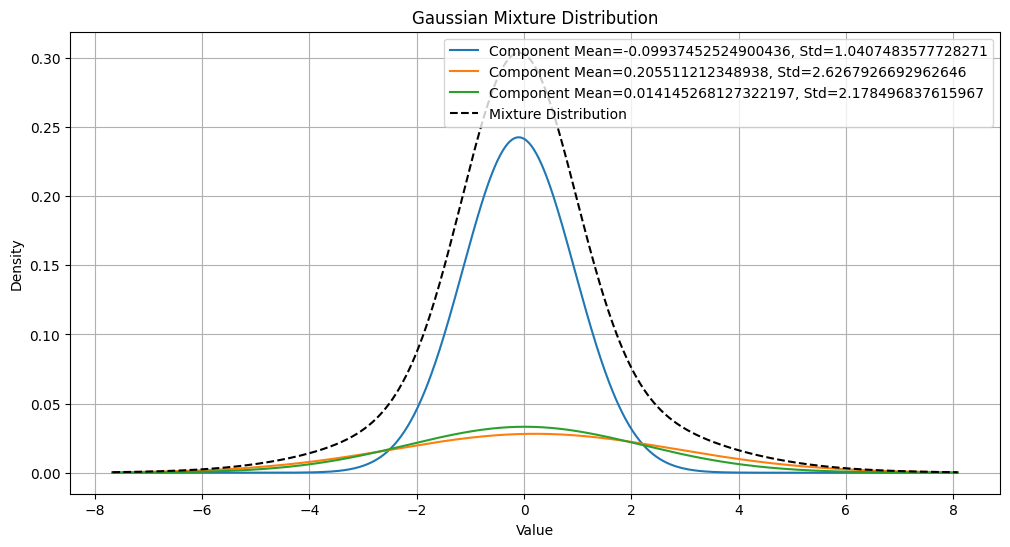

In [273]:
# Extracting parameters for each component
weights = yhat_cw[0].flatten()  # Mixture weights
means = yhat_means[0].flatten()  # Means of the Gaussians
stddevs = yhat_stddev[0].flatten()  # Standard deviations of the Gaussians

# Plot the individual components
x = np.linspace(np.min(means - 3 * stddevs), np.max(means + 3 * stddevs), 1000)
for weight, mean, stddev in zip(weights, means, stddevs):
    plt.plot(x, weight * norm.pdf(x, mean, stddev), label=f'Component Mean={mean}, Std={stddev}')

# Calculate and plot the overall mixture distribution
mixture_pdf = np.sum([weight * norm.pdf(x, mean, stddev) for weight, mean, stddev in zip(weights, means, stddevs)], axis=0)
plt.plot(x, mixture_pdf, 'k--', label='Mixture Distribution')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Gaussian Mixture Distribution')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-274-178e1bffbd2a>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




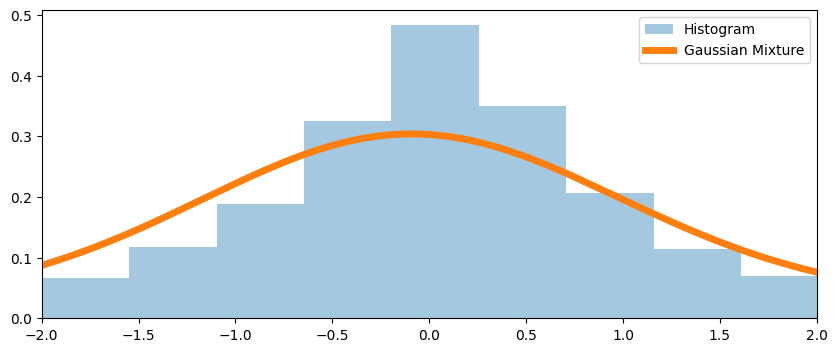

In [274]:
f = plt.figure(figsize=(10,4))
ax = plt.gca()
lower = -2
upper = 2
sns.distplot(Y_validation, bins=50, kde=False, norm_hist=True, ax=ax, label="Histogram")
ax.set_xlim(lower, upper)

x = np.linspace(upper, lower, int(1e4), dtype=np.float32)
ax.plot(x, gm_test.prob(x).numpy(), lw=5, label="Gaussian Mixture")
_ = ax.legend()

# Optimize model

In [103]:
def create_model(trial, lstm_layers, input_shape):
    num_components = 3
    event_shape = [1]
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)

    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    dropout_rate_1 = trial.suggest_float(f"dropout_rate_l", 0, 0.5)
    model = tf.keras.Sequential()
    model.add(Input(input_shape))

    for i in range(lstm_layers):
        num_hidden = trial.suggest_int(f"n_units_l{i}", 15, 120, log=True)
        model.add(
            LSTM(
                num_hidden,
                activation="relu",
                return_sequences=(i < lstm_layers - 1),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
            )
        )
        model.add(LayerNormalization())
        dropout_rate = trial.suggest_float(f"dropout_rate_l{i}", 0.1, 0.5)
        model.add(Dropout(dropout_rate))

    model.add(Dense(params_size, activation=None)),
    model.add(Dropout(dropout_rate_1))
    model.add(tfp.layers.MixtureNormal(num_components, event_shape))
    return model

def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["RMSprop","Adam","SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["weight_decay"] = trial.suggest_float("rmsprop_weight_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

def objective(trial):
    # Suggest hyperparameters
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)

    # Define the model
    input_shape = X_train.shape[1:]  # Shape of each sample (timesteps, features)
    model = create_model(trial, lstm_layers, input_shape)
    optimizer = create_optimizer(trial)

    # loss function for distributions
    loss = lambda y, rv_y: -rv_y.log_prob(y)
    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=["mean_absolute_error"])

    # Train the model
    history = model.fit(
        X_train, Y_train, epochs=20, validation_data=(X_validation, Y_validation),callbacks=get_callbacks(checkpoint_path),  batch_size=BATCH_SIZE
    )

    # Return the final validation loss (negative log-likelihood)
    val_loss = history.history["val_loss"][-1]
    return val_loss

# Run optimization
storage = optuna.storages.InMemoryStorage()
study = optuna.create_study(storage=storage, direction='minimize')
study.optimize(objective, n_trials=30)

# Start Optuna Dashboard
port = 8081
thread = threading.Thread(target=run_server, args=(storage,), kwargs={"port": port})
thread.start()
output.serve_kernel_port_as_window(port, path='/dashboard/')

[I 2024-12-05 10:26:11,610] A new study created in memory with name: no-name-315c3a51-89e3-40bf-bb67-cfe38db33a33


Epoch 1/20
314/314 [==============================] - 17s 42ms/step - loss: 1.6097 - mean_absolute_error: 1.3828 - val_loss: 1.5242 - val_mean_absolute_error: 1.0798 - lr: 0.0027
Epoch 2/20
  5/314 [..............................] - ETA: 8s - loss: 1.4460 - mean_absolute_error: 1.1117

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:159: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         lambda t: MixtureNormal.new(  # pylint: disable=g-long-lambda
            t, num_components, event_shape, validate_args),

  config_arr = [serialize_keras_object(x) for x in obj]


314/314 [==============================] - 12s 39ms/step - loss: 1.2468 - mean_absolute_error: 1.0081 - val_loss: 1.4444 - val_mean_absolute_error: 1.0454 - lr: 0.0027
Epoch 3/20
314/314 [==============================] - 12s 38ms/step - loss: 1.1907 - mean_absolute_error: 0.9851 - val_loss: 1.4591 - val_mean_absolute_error: 1.0584 - lr: 0.0027
Epoch 4/20
314/314 [==============================] - 10s 31ms/step - loss: 1.1717 - mean_absolute_error: 0.9779 - val_loss: 1.5114 - val_mean_absolute_error: 1.0453 - lr: 0.0027
Epoch 5/20
314/314 [==============================] - 12s 38ms/step - loss: 1.1727 - mean_absolute_error: 0.9822 - val_loss: 1.4698 - val_mean_absolute_error: 0.9881 - lr: 0.0027
Epoch 6/20
314/314 [==============================] - 12s 37ms/step - loss: 1.1435 - mean_absolute_error: 0.9621 - val_loss: 1.4866 - val_mean_absolute_error: 1.0196 - lr: 0.0027
Epoch 7/20
314/314 [==============================] - 11s 36ms/step - loss: 1.1378 - mean_absolute_error: 0.9628 - v

[I 2024-12-05 10:28:34,330] Trial 0 finished with value: 1.4582377672195435 and parameters: {'lstm_layers': 1, 'weight_decay': 9.466439383726407e-09, 'dropout_rate_l': 0.3677533791431683, 'n_units_l0': 74, 'dropout_rate_l0': 0.43666774608392045, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.002711295692066483, 'sgd_opt_momentum': 2.3463113756182183e-05}. Best is trial 0 with value: 1.4582377672195435.


Epoch 1/20
314/314 [==============================] - 10s 21ms/step - loss: 1.3716 - mean_absolute_error: 1.0268 - val_loss: 1.5654 - val_mean_absolute_error: 0.9896 - lr: 0.0745
Epoch 2/20
314/314 [==============================] - 7s 22ms/step - loss: 1.3440 - mean_absolute_error: 0.9933 - val_loss: 1.5188 - val_mean_absolute_error: 1.0773 - lr: 0.0745
Epoch 3/20
314/314 [==============================] - 7s 21ms/step - loss: 1.3530 - mean_absolute_error: 0.9811 - val_loss: 1.5041 - val_mean_absolute_error: 1.0029 - lr: 0.0745
Epoch 4/20
314/314 [==============================] - 5s 17ms/step - loss: 1.3428 - mean_absolute_error: 0.9940 - val_loss: 1.5134 - val_mean_absolute_error: 1.0001 - lr: 0.0745
Epoch 5/20
314/314 [==============================] - 7s 23ms/step - loss: 1.3452 - mean_absolute_error: 0.9764 - val_loss: 1.6137 - val_mean_absolute_error: 1.0020 - lr: 0.0745
Epoch 6/20
314/314 [==============================] - 5s 17ms/step - loss: 1.3527 - mean_absolute_error: 0.96

[I 2024-12-05 10:30:43,542] Trial 1 finished with value: 1.4635097980499268 and parameters: {'lstm_layers': 1, 'weight_decay': 4.950994906060654e-07, 'dropout_rate_l': 0.39201936425226713, 'n_units_l0': 17, 'dropout_rate_l0': 0.1190042333344906, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.07449711636586837, 'rmsprop_weight_decay': 0.8725461946112831, 'rmsprop_momentum': 0.09949721826003341}. Best is trial 0 with value: 1.4582377672195435.


Epoch 1/20
314/314 [==============================] - 44s 124ms/step - loss: 1.5723 - mean_absolute_error: 1.3642 - val_loss: 1.4635 - val_mean_absolute_error: 1.1056 - lr: 0.0179
Epoch 2/20
314/314 [==============================] - 36s 114ms/step - loss: 1.3222 - mean_absolute_error: 1.0263 - val_loss: 1.4522 - val_mean_absolute_error: 1.0360 - lr: 0.0179
Epoch 3/20
314/314 [==============================] - 38s 121ms/step - loss: 1.2607 - mean_absolute_error: 0.9951 - val_loss: 1.4720 - val_mean_absolute_error: 1.0567 - lr: 0.0179
Epoch 4/20
314/314 [==============================] - 38s 122ms/step - loss: 1.2642 - mean_absolute_error: 0.9980 - val_loss: 1.4413 - val_mean_absolute_error: 1.0220 - lr: 0.0179
Epoch 5/20
314/314 [==============================] - 36s 113ms/step - loss: 1.2585 - mean_absolute_error: 1.0083 - val_loss: 1.4492 - val_mean_absolute_error: 1.0378 - lr: 0.0179
Epoch 6/20
314/314 [==============================] - 36s 115ms/step - loss: 1.2604 - mean_absolute_

[I 2024-12-05 10:42:32,272] Trial 2 finished with value: 1.4740642309188843 and parameters: {'lstm_layers': 3, 'weight_decay': 2.7962483262644936e-05, 'dropout_rate_l': 0.3059199411649103, 'n_units_l0': 20, 'dropout_rate_l0': 0.28708182345739286, 'n_units_l1': 56, 'dropout_rate_l1': 0.38981838720275486, 'n_units_l2': 91, 'dropout_rate_l2': 0.47619424566294954, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.01789777413396753, 'sgd_opt_momentum': 0.0025530970382259526}. Best is trial 0 with value: 1.4582377672195435.


Epoch 1/20
314/314 [==============================] - 61s 173ms/step - loss: 1.4998 - mean_absolute_error: 1.2437 - val_loss: 1.4332 - val_mean_absolute_error: 1.1193 - lr: 0.0036
Epoch 2/20
314/314 [==============================] - 55s 175ms/step - loss: 1.3974 - mean_absolute_error: 1.1303 - val_loss: 1.4241 - val_mean_absolute_error: 1.1812 - lr: 0.0036
Epoch 3/20
314/314 [==============================] - 48s 152ms/step - loss: 1.3221 - mean_absolute_error: 1.1073 - val_loss: 1.4129 - val_mean_absolute_error: 1.1393 - lr: 0.0036
Epoch 4/20
314/314 [==============================] - 48s 153ms/step - loss: 1.2810 - mean_absolute_error: 1.0671 - val_loss: 1.4462 - val_mean_absolute_error: 1.2018 - lr: 0.0036
Epoch 5/20
314/314 [==============================] - 47s 150ms/step - loss: 1.2476 - mean_absolute_error: 1.0265 - val_loss: 1.4257 - val_mean_absolute_error: 1.0846 - lr: 0.0036
Epoch 6/20
314/314 [==============================] - 47s 150ms/step - loss: 1.2206 - mean_absolute_

[I 2024-12-05 10:54:17,377] Trial 3 finished with value: 1.5102900266647339 and parameters: {'lstm_layers': 4, 'weight_decay': 2.3987968877611603e-05, 'dropout_rate_l': 0.3630072095614699, 'n_units_l0': 95, 'dropout_rate_l0': 0.13341447026624814, 'n_units_l1': 19, 'dropout_rate_l1': 0.3974064441556949, 'n_units_l2': 65, 'dropout_rate_l2': 0.47987270805134596, 'n_units_l3': 19, 'dropout_rate_l3': 0.24833168185455878, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.003594742076635164, 'sgd_opt_momentum': 0.025756309823566238}. Best is trial 0 with value: 1.4582377672195435.


Epoch 1/20
314/314 [==============================] - 11s 25ms/step - loss: 2.0757 - mean_absolute_error: 1.6379 - val_loss: 1.9069 - val_mean_absolute_error: 1.9067 - lr: 1.0168e-05
Epoch 2/20
314/314 [==============================] - 7s 23ms/step - loss: 1.8770 - mean_absolute_error: 1.5571 - val_loss: 1.8292 - val_mean_absolute_error: 1.8687 - lr: 1.0168e-05
Epoch 3/20
314/314 [==============================] - 7s 22ms/step - loss: 1.8520 - mean_absolute_error: 1.5383 - val_loss: 1.8036 - val_mean_absolute_error: 1.9104 - lr: 1.0168e-05
Epoch 4/20
314/314 [==============================] - 7s 21ms/step - loss: 1.7926 - mean_absolute_error: 1.5418 - val_loss: 1.7857 - val_mean_absolute_error: 1.8878 - lr: 1.0168e-05
Epoch 5/20
314/314 [==============================] - 7s 23ms/step - loss: 1.7638 - mean_absolute_error: 1.5211 - val_loss: 1.7677 - val_mean_absolute_error: 1.8146 - lr: 1.0168e-05
Epoch 6/20
314/314 [==============================] - 7s 22ms/step - loss: 1.7377 - mean_

[I 2024-12-05 10:57:24,517] Trial 4 finished with value: 1.561337947845459 and parameters: {'lstm_layers': 1, 'weight_decay': 6.839694961278553e-05, 'dropout_rate_l': 0.0939063318349943, 'n_units_l0': 25, 'dropout_rate_l0': 0.23176634304666024, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 1.0167976048483418e-05, 'sgd_opt_momentum': 1.2023310472270314e-05}. Best is trial 0 with value: 1.4582377672195435.


Epoch 1/20
314/314 [==============================] - 22s 53ms/step - loss: 1.3087 - mean_absolute_error: 1.0225 - val_loss: 1.4293 - val_mean_absolute_error: 1.0714 - lr: 0.0042
Epoch 2/20
314/314 [==============================] - 15s 48ms/step - loss: 1.2287 - mean_absolute_error: 1.0117 - val_loss: 1.7405 - val_mean_absolute_error: 0.8734 - lr: 0.0042
Epoch 3/20
314/314 [==============================] - 15s 48ms/step - loss: 1.2905 - mean_absolute_error: 0.9908 - val_loss: 1.4288 - val_mean_absolute_error: 1.0214 - lr: 0.0042
Epoch 4/20
314/314 [==============================] - 15s 48ms/step - loss: 1.2521 - mean_absolute_error: 0.9957 - val_loss: 1.4525 - val_mean_absolute_error: 1.0324 - lr: 0.0042
Epoch 5/20
314/314 [==============================] - 15s 48ms/step - loss: 1.2624 - mean_absolute_error: 1.0036 - val_loss: 1.4966 - val_mean_absolute_error: 1.0175 - lr: 0.0042
Epoch 6/20
314/314 [==============================] - 15s 47ms/step - loss: 1.2476 - mean_absolute_error:

[I 2024-12-05 11:02:52,566] Trial 5 finished with value: 1.441375970840454 and parameters: {'lstm_layers': 2, 'weight_decay': 8.372999628112566e-05, 'dropout_rate_l': 0.31640091591394226, 'n_units_l0': 19, 'dropout_rate_l0': 0.42063674725277556, 'n_units_l1': 42, 'dropout_rate_l1': 0.2193602572357002, 'optimizer': 'Adam', 'adam_learning_rate': 0.004179360208928909}. Best is trial 5 with value: 1.441375970840454.


Epoch 1/20
314/314 [==============================] - 35s 97ms/step - loss: 1.2970 - mean_absolute_error: 1.0958 - val_loss: 1.5960 - val_mean_absolute_error: 0.9619 - lr: 0.0059
Epoch 2/20
314/314 [==============================] - 30s 96ms/step - loss: 1.1551 - mean_absolute_error: 0.9905 - val_loss: 1.4717 - val_mean_absolute_error: 1.0514 - lr: 0.0059
Epoch 3/20
314/314 [==============================] - 30s 94ms/step - loss: 1.1288 - mean_absolute_error: 0.9804 - val_loss: 1.5650 - val_mean_absolute_error: 0.9285 - lr: 0.0059
Epoch 4/20
314/314 [==============================] - 29s 94ms/step - loss: 1.1163 - mean_absolute_error: 0.9817 - val_loss: 1.5835 - val_mean_absolute_error: 0.9377 - lr: 0.0059
Epoch 5/20
314/314 [==============================] - 30s 94ms/step - loss: 1.0955 - mean_absolute_error: 0.9674 - val_loss: 1.6033 - val_mean_absolute_error: 0.9438 - lr: 0.0059
Epoch 6/20
314/314 [==============================] - 28s 90ms/step - loss: 1.0930 - mean_absolute_error:

[I 2024-12-05 11:08:54,486] Trial 6 finished with value: 1.5381666421890259 and parameters: {'lstm_layers': 2, 'weight_decay': 5.278381201676054e-10, 'dropout_rate_l': 0.26687607604230207, 'n_units_l0': 54, 'dropout_rate_l0': 0.3469561193308366, 'n_units_l1': 83, 'dropout_rate_l1': 0.247455299329734, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.005933355479283846, 'sgd_opt_momentum': 2.2445276404597994e-05}. Best is trial 5 with value: 1.441375970840454.


Epoch 1/20
314/314 [==============================] - 39s 107ms/step - loss: 2.1743 - mean_absolute_error: 2.0621 - val_loss: 1.7046 - val_mean_absolute_error: 1.7384 - lr: 2.1526e-05
Epoch 2/20
314/314 [==============================] - 33s 105ms/step - loss: 1.7222 - mean_absolute_error: 1.7542 - val_loss: 1.5965 - val_mean_absolute_error: 1.5630 - lr: 2.1526e-05
Epoch 3/20
314/314 [==============================] - 33s 107ms/step - loss: 1.6299 - mean_absolute_error: 1.5285 - val_loss: 1.4966 - val_mean_absolute_error: 1.4039 - lr: 2.1526e-05
Epoch 4/20
314/314 [==============================] - 36s 113ms/step - loss: 1.6192 - mean_absolute_error: 1.4201 - val_loss: 1.4884 - val_mean_absolute_error: 1.3267 - lr: 2.1526e-05
Epoch 5/20
314/314 [==============================] - 33s 107ms/step - loss: 1.5990 - mean_absolute_error: 1.3576 - val_loss: 1.4747 - val_mean_absolute_error: 1.2036 - lr: 2.1526e-05
Epoch 6/20
314/314 [==============================] - 34s 110ms/step - loss: 1.5

[I 2024-12-05 11:17:48,074] Trial 7 finished with value: 1.6028093099594116 and parameters: {'lstm_layers': 3, 'weight_decay': 3.926368885991721e-09, 'dropout_rate_l': 0.4747078882039844, 'n_units_l0': 30, 'dropout_rate_l0': 0.14213227300515602, 'n_units_l1': 19, 'dropout_rate_l1': 0.31371576516503846, 'n_units_l2': 95, 'dropout_rate_l2': 0.13083733271330944, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 2.1526037729000778e-05, 'sgd_opt_momentum': 0.0030599881898665925}. Best is trial 5 with value: 1.441375970840454.


Epoch 1/20
314/314 [==============================] - 33s 87ms/step - loss: 1.5491 - mean_absolute_error: 1.2686 - val_loss: 1.4606 - val_mean_absolute_error: 1.0493 - lr: 1.1800e-04
Epoch 2/20
314/314 [==============================] - 24s 78ms/step - loss: 1.3131 - mean_absolute_error: 1.0915 - val_loss: 1.5346 - val_mean_absolute_error: 1.0335 - lr: 1.1800e-04
Epoch 3/20
314/314 [==============================] - 25s 81ms/step - loss: 1.2200 - mean_absolute_error: 1.0310 - val_loss: 1.4869 - val_mean_absolute_error: 1.0302 - lr: 1.1800e-04
Epoch 4/20
314/314 [==============================] - 24s 78ms/step - loss: 1.1562 - mean_absolute_error: 0.9888 - val_loss: 1.5497 - val_mean_absolute_error: 0.9437 - lr: 1.1800e-04
Epoch 5/20
314/314 [==============================] - 23s 75ms/step - loss: 1.1390 - mean_absolute_error: 0.9612 - val_loss: 1.4733 - val_mean_absolute_error: 1.0070 - lr: 1.1800e-04
Epoch 6/20
314/314 [==============================] - 24s 77ms/step - loss: 1.1157 - 

[I 2024-12-05 11:25:39,498] Trial 8 finished with value: 1.415265679359436 and parameters: {'lstm_layers': 3, 'weight_decay': 3.3920833565694905e-10, 'dropout_rate_l': 0.26629350796954243, 'n_units_l0': 43, 'dropout_rate_l0': 0.22588311672952743, 'n_units_l1': 27, 'dropout_rate_l1': 0.4753590454401847, 'n_units_l2': 22, 'dropout_rate_l2': 0.1218959031318264, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.00011799567237879968, 'rmsprop_weight_decay': 0.9403785586545031, 'rmsprop_momentum': 2.419095919701553e-05}. Best is trial 8 with value: 1.415265679359436.


Epoch 1/20
314/314 [==============================] - 38s 105ms/step - loss: 1.3992 - mean_absolute_error: 1.1099 - val_loss: 1.4988 - val_mean_absolute_error: 0.9423 - lr: 0.0011
Epoch 2/20
314/314 [==============================] - 33s 104ms/step - loss: 1.2505 - mean_absolute_error: 0.9913 - val_loss: 1.4766 - val_mean_absolute_error: 0.9663 - lr: 0.0011
Epoch 3/20
314/314 [==============================] - 33s 104ms/step - loss: 1.2227 - mean_absolute_error: 0.9927 - val_loss: 1.4669 - val_mean_absolute_error: 0.9525 - lr: 0.0011
Epoch 4/20
314/314 [==============================] - 33s 106ms/step - loss: 1.2149 - mean_absolute_error: 0.9984 - val_loss: 1.4307 - val_mean_absolute_error: 0.9790 - lr: 0.0011
Epoch 5/20
314/314 [==============================] - 33s 106ms/step - loss: 1.1847 - mean_absolute_error: 0.9948 - val_loss: 1.4537 - val_mean_absolute_error: 0.9654 - lr: 0.0011
Epoch 6/20
314/314 [==============================] - 34s 108ms/step - loss: 1.1643 - mean_absolute_

[I 2024-12-05 11:35:39,965] Trial 9 finished with value: 1.4575334787368774 and parameters: {'lstm_layers': 3, 'weight_decay': 1.8689083678723053e-05, 'dropout_rate_l': 0.07571051899143721, 'n_units_l0': 78, 'dropout_rate_l0': 0.10018389924412854, 'n_units_l1': 19, 'dropout_rate_l1': 0.18240938192733888, 'n_units_l2': 23, 'dropout_rate_l2': 0.3825898685945227, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0011472427449383273, 'sgd_opt_momentum': 0.00010416457679802997}. Best is trial 8 with value: 1.415265679359436.


Epoch 1/20
314/314 [==============================] - 52s 138ms/step - loss: 2.2882 - mean_absolute_error: 2.0988 - val_loss: 1.5922 - val_mean_absolute_error: 1.2414 - lr: 1.9542e-05
Epoch 2/20
314/314 [==============================] - 45s 142ms/step - loss: 1.9835 - mean_absolute_error: 1.9168 - val_loss: 1.5423 - val_mean_absolute_error: 1.1518 - lr: 1.9542e-05
Epoch 3/20
314/314 [==============================] - 46s 146ms/step - loss: 1.8076 - mean_absolute_error: 1.6868 - val_loss: 1.4736 - val_mean_absolute_error: 1.0791 - lr: 1.9542e-05
Epoch 4/20
314/314 [==============================] - 46s 146ms/step - loss: 1.6517 - mean_absolute_error: 1.4655 - val_loss: 1.4368 - val_mean_absolute_error: 1.0541 - lr: 1.9542e-05
Epoch 5/20
314/314 [==============================] - 45s 144ms/step - loss: 1.5337 - mean_absolute_error: 1.3241 - val_loss: 1.4328 - val_mean_absolute_error: 1.0306 - lr: 1.9542e-05
Epoch 6/20
314/314 [==============================] - 44s 139ms/step - loss: 1.4

[I 2024-12-05 11:51:12,561] Trial 10 finished with value: 1.4118353128433228 and parameters: {'lstm_layers': 4, 'weight_decay': 1.017297045567999e-10, 'dropout_rate_l': 0.16661905773943947, 'n_units_l0': 46, 'dropout_rate_l0': 0.22942871733555353, 'n_units_l1': 29, 'dropout_rate_l1': 0.48519683102841743, 'n_units_l2': 15, 'dropout_rate_l2': 0.10380288403671144, 'n_units_l3': 109, 'dropout_rate_l3': 0.49698959299687856, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 1.9542127434921943e-05, 'rmsprop_weight_decay': 0.9723739504817333, 'rmsprop_momentum': 1.966479176826036e-05}. Best is trial 10 with value: 1.4118353128433228.


Epoch 1/20
314/314 [==============================] - 56s 154ms/step - loss: 2.3354 - mean_absolute_error: 2.0340 - val_loss: 1.6323 - val_mean_absolute_error: 1.2867 - lr: 1.4043e-05
Epoch 2/20
314/314 [==============================] - 47s 148ms/step - loss: 1.9514 - mean_absolute_error: 1.8871 - val_loss: 1.5652 - val_mean_absolute_error: 1.2421 - lr: 1.4043e-05
Epoch 3/20
314/314 [==============================] - 47s 148ms/step - loss: 1.8309 - mean_absolute_error: 1.7254 - val_loss: 1.5169 - val_mean_absolute_error: 1.2213 - lr: 1.4043e-05
Epoch 4/20
314/314 [==============================] - 43s 138ms/step - loss: 1.7452 - mean_absolute_error: 1.5701 - val_loss: 1.5195 - val_mean_absolute_error: 1.1772 - lr: 1.4043e-05
Epoch 5/20
314/314 [==============================] - 47s 149ms/step - loss: 1.6502 - mean_absolute_error: 1.4514 - val_loss: 1.5290 - val_mean_absolute_error: 1.1648 - lr: 1.4043e-05
Epoch 6/20
314/314 [==============================] - 48s 152ms/step - loss: 1.5

[I 2024-12-05 12:07:42,755] Trial 11 finished with value: 1.4505327939987183 and parameters: {'lstm_layers': 4, 'weight_decay': 1.0411628318931615e-10, 'dropout_rate_l': 0.1672565159481655, 'n_units_l0': 40, 'dropout_rate_l0': 0.2189307891034322, 'n_units_l1': 31, 'dropout_rate_l1': 0.4993603573263908, 'n_units_l2': 15, 'dropout_rate_l2': 0.10077870261896715, 'n_units_l3': 118, 'dropout_rate_l3': 0.47172381298008126, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 1.4043253100556866e-05, 'rmsprop_weight_decay': 0.9745473657445048, 'rmsprop_momentum': 1.17703520720882e-05}. Best is trial 10 with value: 1.4118353128433228.


Epoch 1/20
314/314 [==============================] - 57s 156ms/step - loss: 2.4509 - mean_absolute_error: 2.0076 - val_loss: 1.7202 - val_mean_absolute_error: 1.6646 - lr: 3.5034e-05
Epoch 2/20
314/314 [==============================] - 48s 152ms/step - loss: 1.9222 - mean_absolute_error: 1.8704 - val_loss: 1.6070 - val_mean_absolute_error: 1.3961 - lr: 3.5034e-05
Epoch 3/20
314/314 [==============================] - 49s 155ms/step - loss: 1.7211 - mean_absolute_error: 1.5946 - val_loss: 1.5731 - val_mean_absolute_error: 1.1412 - lr: 3.5034e-05
Epoch 4/20
314/314 [==============================] - 50s 161ms/step - loss: 1.5162 - mean_absolute_error: 1.2896 - val_loss: 1.7831 - val_mean_absolute_error: 0.9739 - lr: 3.5034e-05
Epoch 5/20
314/314 [==============================] - 50s 160ms/step - loss: 1.3941 - mean_absolute_error: 1.1642 - val_loss: 2.0657 - val_mean_absolute_error: 0.9184 - lr: 3.5034e-05
Epoch 6/20
314/314 [==============================] - 49s 156ms/step - loss: 1.3

[I 2024-12-05 12:25:13,884] Trial 12 finished with value: 1.6007028818130493 and parameters: {'lstm_layers': 4, 'weight_decay': 7.045977594594596e-08, 'dropout_rate_l': 0.20581320574578865, 'n_units_l0': 45, 'dropout_rate_l0': 0.22516449046728995, 'n_units_l1': 29, 'dropout_rate_l1': 0.49815102726569266, 'n_units_l2': 25, 'dropout_rate_l2': 0.23306406568479415, 'n_units_l3': 118, 'dropout_rate_l3': 0.48885586276394033, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 3.503357281053183e-05, 'rmsprop_weight_decay': 0.9623972439795059, 'rmsprop_momentum': 1.294536324196476e-05}. Best is trial 10 with value: 1.4118353128433228.


Epoch 1/20
314/314 [==============================] - 39s 102ms/step - loss: 1.2362 - mean_absolute_error: 1.0206 - val_loss: 1.4051 - val_mean_absolute_error: 1.1259 - lr: 2.8585e-04
Epoch 2/20
314/314 [==============================] - 31s 98ms/step - loss: 1.0708 - mean_absolute_error: 0.9368 - val_loss: 1.3996 - val_mean_absolute_error: 1.1708 - lr: 2.8585e-04
Epoch 3/20
314/314 [==============================] - 31s 100ms/step - loss: 1.0374 - mean_absolute_error: 0.9173 - val_loss: 1.3940 - val_mean_absolute_error: 1.1742 - lr: 2.8585e-04
Epoch 4/20
314/314 [==============================] - 30s 97ms/step - loss: 1.0158 - mean_absolute_error: 0.9127 - val_loss: 1.3938 - val_mean_absolute_error: 1.0674 - lr: 2.8585e-04
Epoch 5/20
314/314 [==============================] - 30s 97ms/step - loss: 1.0002 - mean_absolute_error: 0.9079 - val_loss: 1.3817 - val_mean_absolute_error: 1.1341 - lr: 2.8585e-04
Epoch 6/20
314/314 [==============================] - 32s 103ms/step - loss: 0.9890

[I 2024-12-05 12:33:28,693] Trial 13 finished with value: 1.4072057008743286 and parameters: {'lstm_layers': 4, 'weight_decay': 2.0767458282093298e-10, 'dropout_rate_l': 0.005316984856009066, 'n_units_l0': 33, 'dropout_rate_l0': 0.3094739744537587, 'n_units_l1': 30, 'dropout_rate_l1': 0.41490097058492714, 'n_units_l2': 15, 'dropout_rate_l2': 0.21289486787162312, 'n_units_l3': 44, 'dropout_rate_l3': 0.11693027115885501, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.00028584633775766887, 'rmsprop_weight_decay': 0.9445789471318055, 'rmsprop_momentum': 0.00022349106092368304}. Best is trial 13 with value: 1.4072057008743286.


Epoch 1/20
314/314 [==============================] - 41s 104ms/step - loss: 1.1580 - mean_absolute_error: 0.9909 - val_loss: 1.3911 - val_mean_absolute_error: 1.1185 - lr: 8.7994e-04
Epoch 2/20
314/314 [==============================] - 32s 101ms/step - loss: 1.0195 - mean_absolute_error: 0.9061 - val_loss: 1.4130 - val_mean_absolute_error: 1.0694 - lr: 8.7994e-04
Epoch 3/20
314/314 [==============================] - 34s 108ms/step - loss: 0.9953 - mean_absolute_error: 0.8997 - val_loss: 1.4219 - val_mean_absolute_error: 0.9918 - lr: 8.7994e-04
Epoch 4/20
314/314 [==============================] - 32s 101ms/step - loss: 0.9854 - mean_absolute_error: 0.8925 - val_loss: 1.3890 - val_mean_absolute_error: 1.0766 - lr: 8.7994e-04
Epoch 5/20
314/314 [==============================] - 32s 101ms/step - loss: 0.9850 - mean_absolute_error: 0.8960 - val_loss: 1.3847 - val_mean_absolute_error: 1.0900 - lr: 8.7994e-04
Epoch 6/20
314/314 [==============================] - 32s 103ms/step - loss: 0.9

[I 2024-12-05 12:45:01,780] Trial 14 finished with value: 1.3822829723358154 and parameters: {'lstm_layers': 4, 'weight_decay': 3.0159795423877393e-09, 'dropout_rate_l': 0.005004069554017029, 'n_units_l0': 31, 'dropout_rate_l0': 0.33895797478523726, 'n_units_l1': 41, 'dropout_rate_l1': 0.1041040777095597, 'n_units_l2': 15, 'dropout_rate_l2': 0.23420018777218837, 'n_units_l3': 45, 'dropout_rate_l3': 0.11839404244466376, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0008799413250958084, 'rmsprop_weight_decay': 0.9183082117122622, 'rmsprop_momentum': 0.0005886109011309948}. Best is trial 14 with value: 1.3822829723358154.


Epoch 1/20
314/314 [==============================] - 47s 126ms/step - loss: 1.5435 - mean_absolute_error: 1.3508 - val_loss: 1.6124 - val_mean_absolute_error: 1.4489 - lr: 1.7516e-05
Epoch 2/20
314/314 [==============================] - 35s 113ms/step - loss: 1.2815 - mean_absolute_error: 1.1245 - val_loss: 1.5262 - val_mean_absolute_error: 1.3315 - lr: 1.7516e-05
Epoch 3/20
314/314 [==============================] - 36s 115ms/step - loss: 1.2187 - mean_absolute_error: 1.0605 - val_loss: 1.4735 - val_mean_absolute_error: 1.2350 - lr: 1.7516e-05
Epoch 4/20
314/314 [==============================] - 36s 116ms/step - loss: 1.1820 - mean_absolute_error: 1.0235 - val_loss: 1.4407 - val_mean_absolute_error: 1.1833 - lr: 1.7516e-05
Epoch 5/20
314/314 [==============================] - 36s 114ms/step - loss: 1.1635 - mean_absolute_error: 1.0148 - val_loss: 1.4252 - val_mean_absolute_error: 1.1409 - lr: 1.7516e-05
Epoch 6/20
314/314 [==============================] - 38s 120ms/step - loss: 1.1

[I 2024-12-05 12:57:33,165] Trial 15 finished with value: 1.407505989074707 and parameters: {'lstm_layers': 4, 'weight_decay': 4.0624877836230955e-09, 'dropout_rate_l': 0.010823026855393783, 'n_units_l0': 29, 'dropout_rate_l0': 0.3592239642190512, 'n_units_l1': 51, 'dropout_rate_l1': 0.3229126079211999, 'n_units_l2': 39, 'dropout_rate_l2': 0.26289775997010656, 'n_units_l3': 43, 'dropout_rate_l3': 0.10743532496066147, 'optimizer': 'Adam', 'adam_learning_rate': 1.7515870665538284e-05}. Best is trial 14 with value: 1.3822829723358154.


Epoch 1/20
314/314 [==============================] - 49s 134ms/step - loss: 1.1641 - mean_absolute_error: 0.9897 - val_loss: 1.4371 - val_mean_absolute_error: 1.0587 - lr: 0.0017
Epoch 2/20
314/314 [==============================] - 37s 117ms/step - loss: 1.0174 - mean_absolute_error: 0.9011 - val_loss: 1.5354 - val_mean_absolute_error: 0.9381 - lr: 0.0017
Epoch 3/20
314/314 [==============================] - 40s 127ms/step - loss: 1.0031 - mean_absolute_error: 0.8998 - val_loss: 1.3938 - val_mean_absolute_error: 1.0408 - lr: 0.0017
Epoch 4/20
314/314 [==============================] - 38s 120ms/step - loss: 0.9988 - mean_absolute_error: 0.8991 - val_loss: 1.3864 - val_mean_absolute_error: 1.0613 - lr: 0.0017
Epoch 5/20
314/314 [==============================] - 39s 125ms/step - loss: 1.0013 - mean_absolute_error: 0.8856 - val_loss: 1.4237 - val_mean_absolute_error: 1.0576 - lr: 0.0017
Epoch 6/20
314/314 [==============================] - 37s 117ms/step - loss: 1.0010 - mean_absolute_

[I 2024-12-05 13:10:24,756] Trial 16 finished with value: 1.4445048570632935 and parameters: {'lstm_layers': 4, 'weight_decay': 3.23212301580237e-07, 'dropout_rate_l': 0.014504185965796373, 'n_units_l0': 33, 'dropout_rate_l0': 0.3736497403873816, 'n_units_l1': 65, 'dropout_rate_l1': 0.10508898821453283, 'n_units_l2': 36, 'dropout_rate_l2': 0.2063157674361019, 'n_units_l3': 44, 'dropout_rate_l3': 0.10603955576037447, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.001737107432465921, 'rmsprop_weight_decay': 0.9061574555075472, 'rmsprop_momentum': 0.000689699001331265}. Best is trial 14 with value: 1.3822829723358154.


Epoch 1/20
314/314 [==============================] - 35s 100ms/step - loss: 1.1640 - mean_absolute_error: 0.9866 - val_loss: 1.4319 - val_mean_absolute_error: 1.0160 - lr: 0.0010
Epoch 2/20
314/314 [==============================] - 31s 99ms/step - loss: 1.0348 - mean_absolute_error: 0.9192 - val_loss: 1.3777 - val_mean_absolute_error: 1.0201 - lr: 0.0010
Epoch 3/20
314/314 [==============================] - 31s 98ms/step - loss: 1.0131 - mean_absolute_error: 0.8960 - val_loss: 1.3667 - val_mean_absolute_error: 1.1284 - lr: 0.0010
Epoch 4/20
314/314 [==============================] - 30s 97ms/step - loss: 1.0057 - mean_absolute_error: 0.9011 - val_loss: 1.3614 - val_mean_absolute_error: 1.0706 - lr: 0.0010
Epoch 5/20
314/314 [==============================] - 30s 97ms/step - loss: 1.0037 - mean_absolute_error: 0.9010 - val_loss: 1.3945 - val_mean_absolute_error: 0.9960 - lr: 0.0010
Epoch 6/20
314/314 [==============================] - 32s 102ms/step - loss: 0.9983 - mean_absolute_erro

[I 2024-12-05 13:20:20,763] Trial 17 finished with value: 1.3693817853927612 and parameters: {'lstm_layers': 2, 'weight_decay': 0.0009589630194722578, 'dropout_rate_l': 0.10158389081007814, 'n_units_l0': 23, 'dropout_rate_l0': 0.4942658863780058, 'n_units_l1': 114, 'dropout_rate_l1': 0.10012915563040087, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0010167448228677123, 'rmsprop_weight_decay': 0.9134727375670254, 'rmsprop_momentum': 0.0006098891603443015}. Best is trial 17 with value: 1.3693817853927612.


Epoch 1/20
314/314 [==============================] - 33s 93ms/step - loss: 1.1426 - mean_absolute_error: 0.9841 - val_loss: 1.3825 - val_mean_absolute_error: 1.1214 - lr: 0.0027
Epoch 2/20
314/314 [==============================] - 31s 98ms/step - loss: 1.0270 - mean_absolute_error: 0.9074 - val_loss: 1.3730 - val_mean_absolute_error: 1.1575 - lr: 0.0027
Epoch 3/20
314/314 [==============================] - 29s 94ms/step - loss: 1.0345 - mean_absolute_error: 0.9083 - val_loss: 1.4060 - val_mean_absolute_error: 1.2591 - lr: 0.0027
Epoch 4/20
314/314 [==============================] - 26s 83ms/step - loss: 1.0210 - mean_absolute_error: 0.9063 - val_loss: 1.3823 - val_mean_absolute_error: 1.1028 - lr: 0.0027
Epoch 5/20
314/314 [==============================] - 28s 88ms/step - loss: 1.0162 - mean_absolute_error: 0.9054 - val_loss: 1.4693 - val_mean_absolute_error: 0.9320 - lr: 0.0027
Epoch 6/20
314/314 [==============================] - 29s 91ms/step - loss: 1.0198 - mean_absolute_error:

[I 2024-12-05 13:27:59,507] Trial 18 finished with value: 1.4118149280548096 and parameters: {'lstm_layers': 2, 'weight_decay': 0.0008231432735553606, 'dropout_rate_l': 0.09308258202480076, 'n_units_l0': 24, 'dropout_rate_l0': 0.47840659868723284, 'n_units_l1': 107, 'dropout_rate_l1': 0.10874824555472447, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.002715977764243529, 'rmsprop_weight_decay': 0.9036211926990456, 'rmsprop_momentum': 0.010923986727288013}. Best is trial 17 with value: 1.3693817853927612.


Epoch 1/20
314/314 [==============================] - 32s 75ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: 0.7324 - lr: 0.0939
Epoch 2/20
314/314 [==============================] - 25s 80ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: 0.7324 - lr: 0.0939
Epoch 3/20
314/314 [==============================] - 24s 76ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: 0.7324 - lr: 0.0939
Epoch 4/20
314/314 [==============================] - 26s 82ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: 0.7324 - lr: 0.0939
Epoch 5/20
314/314 [==============================] - 23s 72ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: 0.7324 - lr: 0.0939
Epoch 6/20
314/314 [==============================] - 25s 80ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: 

[W 2024-12-05 13:32:09,912] Trial 19 failed with parameters: {'lstm_layers': 2, 'weight_decay': 1.6112537774900423e-06, 'dropout_rate_l': 0.057326957663248045, 'n_units_l0': 15, 'dropout_rate_l0': 0.4736653993843643, 'n_units_l1': 79, 'dropout_rate_l1': 0.16597899680070577, 'optimizer': 'Adam', 'adam_learning_rate': 0.09391417193006457} because of the following error: The value nan is not acceptable.
[W 2024-12-05 13:32:09,918] Trial 19 failed with value nan.


Epoch 1/20
314/314 [==============================] - 35s 97ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: 0.7324 - lr: 0.0889
Epoch 2/20
314/314 [==============================] - 31s 97ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: 0.7324 - lr: 0.0889
Epoch 3/20
314/314 [==============================] - 31s 97ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: 0.7324 - lr: 0.0889
Epoch 4/20
314/314 [==============================] - 29s 94ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: 0.7324 - lr: 0.0889
Epoch 5/20
314/314 [==============================] - 29s 93ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: 0.7324 - lr: 0.0889
Epoch 6/20
314/314 [==============================] - 31s 99ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: 

[W 2024-12-05 13:37:18,741] Trial 20 failed with parameters: {'lstm_layers': 2, 'weight_decay': 2.6182199018942142e-06, 'dropout_rate_l': 0.06721847029006373, 'n_units_l0': 16, 'dropout_rate_l0': 0.4881399780806817, 'n_units_l1': 117, 'dropout_rate_l1': 0.1574255574686602, 'optimizer': 'Adam', 'adam_learning_rate': 0.08891132184473774} because of the following error: The value nan is not acceptable.
[W 2024-12-05 13:37:18,745] Trial 20 failed with value nan.


Epoch 1/20
314/314 [==============================] - 32s 89ms/step - loss: 1.2721 - mean_absolute_error: 1.0669 - val_loss: 1.4694 - val_mean_absolute_error: 1.0304 - lr: 0.0438
Epoch 2/20
314/314 [==============================] - 25s 78ms/step - loss: 1.1709 - mean_absolute_error: 0.9708 - val_loss: 1.4769 - val_mean_absolute_error: 1.0775 - lr: 0.0438
Epoch 3/20
314/314 [==============================] - 27s 85ms/step - loss: 1.1645 - mean_absolute_error: 0.9826 - val_loss: 1.4697 - val_mean_absolute_error: 1.0837 - lr: 0.0438
Epoch 4/20
314/314 [==============================] - 29s 92ms/step - loss: 1.1697 - mean_absolute_error: 0.9811 - val_loss: 1.3943 - val_mean_absolute_error: 1.0956 - lr: 0.0438
Epoch 5/20
314/314 [==============================] - 27s 87ms/step - loss: 1.1753 - mean_absolute_error: 0.9805 - val_loss: 1.4209 - val_mean_absolute_error: 1.0852 - lr: 0.0438
Epoch 6/20
314/314 [==============================] - 24s 77ms/step - loss: 1.1872 - mean_absolute_error:

[I 2024-12-05 13:46:45,682] Trial 21 finished with value: 1.4288976192474365 and parameters: {'lstm_layers': 2, 'weight_decay': 1.3493158092851553e-06, 'dropout_rate_l': 0.06720502948364449, 'n_units_l0': 16, 'dropout_rate_l0': 0.49921660126079953, 'n_units_l1': 102, 'dropout_rate_l1': 0.1560131935095826, 'optimizer': 'Adam', 'adam_learning_rate': 0.04383476125007491}. Best is trial 17 with value: 1.3693817853927612.


Epoch 1/20
314/314 [==============================] - 39s 105ms/step - loss: 1.2493 - mean_absolute_error: 0.9984 - val_loss: 1.4263 - val_mean_absolute_error: 1.0400 - lr: 0.0103
Epoch 2/20
314/314 [==============================] - 31s 99ms/step - loss: 1.1983 - mean_absolute_error: 0.9589 - val_loss: 1.4407 - val_mean_absolute_error: 1.0400 - lr: 0.0103
Epoch 3/20
314/314 [==============================] - 32s 101ms/step - loss: 1.2021 - mean_absolute_error: 0.9594 - val_loss: 1.4075 - val_mean_absolute_error: 1.1138 - lr: 0.0103
Epoch 4/20
314/314 [==============================] - 32s 100ms/step - loss: 1.2044 - mean_absolute_error: 0.9687 - val_loss: 1.4548 - val_mean_absolute_error: 1.0504 - lr: 0.0103
Epoch 5/20
314/314 [==============================] - 31s 100ms/step - loss: 1.2071 - mean_absolute_error: 0.9695 - val_loss: 1.4098 - val_mean_absolute_error: 1.1031 - lr: 0.0103
Epoch 6/20
314/314 [==============================] - 31s 99ms/step - loss: 1.2041 - mean_absolute_er

[I 2024-12-05 13:53:42,792] Trial 22 finished with value: 1.4321808815002441 and parameters: {'lstm_layers': 3, 'weight_decay': 2.18377021724197e-08, 'dropout_rate_l': 0.14632919518272988, 'n_units_l0': 22, 'dropout_rate_l0': 0.4262431620920539, 'n_units_l1': 71, 'dropout_rate_l1': 0.1570540190553188, 'n_units_l2': 57, 'dropout_rate_l2': 0.339619840756505, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.01031707648487844, 'rmsprop_weight_decay': 0.8756824711820923, 'rmsprop_momentum': 0.0026749462521148564}. Best is trial 17 with value: 1.3693817853927612.


Epoch 1/20
314/314 [==============================] - 22s 56ms/step - loss: 1.3581 - mean_absolute_error: 1.1723 - val_loss: 1.5997 - val_mean_absolute_error: 0.9838 - lr: 3.7844e-04
Epoch 2/20
314/314 [==============================] - 16s 52ms/step - loss: 1.0971 - mean_absolute_error: 0.9511 - val_loss: 1.4758 - val_mean_absolute_error: 1.0231 - lr: 3.7844e-04
Epoch 3/20
314/314 [==============================] - 16s 52ms/step - loss: 1.0420 - mean_absolute_error: 0.9187 - val_loss: 1.4291 - val_mean_absolute_error: 1.0694 - lr: 3.7844e-04
Epoch 4/20
314/314 [==============================] - 16s 52ms/step - loss: 1.0227 - mean_absolute_error: 0.9061 - val_loss: 1.4322 - val_mean_absolute_error: 1.0419 - lr: 3.7844e-04
Epoch 5/20
314/314 [==============================] - 17s 53ms/step - loss: 1.0109 - mean_absolute_error: 0.9039 - val_loss: 1.4177 - val_mean_absolute_error: 1.0569 - lr: 3.7844e-04
Epoch 6/20
314/314 [==============================] - 18s 56ms/step - loss: 1.0049 - 

[I 2024-12-05 14:00:09,446] Trial 23 finished with value: 1.3743034601211548 and parameters: {'lstm_layers': 2, 'weight_decay': 1.3545343510530437e-09, 'dropout_rate_l': 0.013957888307038993, 'n_units_l0': 34, 'dropout_rate_l0': 0.29675171230668695, 'n_units_l1': 39, 'dropout_rate_l1': 0.3994770195792447, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.00037843851939796413, 'rmsprop_weight_decay': 0.9293067669029756, 'rmsprop_momentum': 0.0002591757594785494}. Best is trial 17 with value: 1.3693817853927612.


Epoch 1/20
314/314 [==============================] - 28s 71ms/step - loss: 1.1825 - mean_absolute_error: 1.0030 - val_loss: 1.3953 - val_mean_absolute_error: 1.2516 - lr: 5.7950e-04
Epoch 2/20
314/314 [==============================] - 21s 66ms/step - loss: 1.0556 - mean_absolute_error: 0.9272 - val_loss: 1.3800 - val_mean_absolute_error: 1.0425 - lr: 5.7950e-04
Epoch 3/20
314/314 [==============================] - 21s 68ms/step - loss: 1.0266 - mean_absolute_error: 0.9112 - val_loss: 1.3733 - val_mean_absolute_error: 1.1133 - lr: 5.7950e-04
Epoch 4/20
314/314 [==============================] - 21s 65ms/step - loss: 1.0106 - mean_absolute_error: 0.8943 - val_loss: 1.4100 - val_mean_absolute_error: 0.9794 - lr: 5.7950e-04
Epoch 5/20
314/314 [==============================] - 19s 62ms/step - loss: 1.0007 - mean_absolute_error: 0.8940 - val_loss: 1.3698 - val_mean_absolute_error: 1.1140 - lr: 5.7950e-04
Epoch 6/20
314/314 [==============================] - 22s 69ms/step - loss: 0.9939 - 

[I 2024-12-05 14:05:48,950] Trial 24 finished with value: 1.3733904361724854 and parameters: {'lstm_layers': 2, 'weight_decay': 1.355868830998909e-09, 'dropout_rate_l': 0.05005437121793403, 'n_units_l0': 59, 'dropout_rate_l0': 0.283960545282633, 'n_units_l1': 40, 'dropout_rate_l1': 0.26349847784171865, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0005794995915666023, 'rmsprop_weight_decay': 0.9226195609160813, 'rmsprop_momentum': 0.00023590728964396147}. Best is trial 17 with value: 1.3693817853927612.


Epoch 1/20
314/314 [==============================] - 28s 76ms/step - loss: 1.4626 - mean_absolute_error: 1.2750 - val_loss: 1.3828 - val_mean_absolute_error: 1.0725 - lr: 2.2361e-04
Epoch 2/20
314/314 [==============================] - 22s 70ms/step - loss: 1.1551 - mean_absolute_error: 0.9944 - val_loss: 1.4210 - val_mean_absolute_error: 0.9660 - lr: 2.2361e-04
Epoch 3/20
314/314 [==============================] - 22s 71ms/step - loss: 1.0855 - mean_absolute_error: 0.9529 - val_loss: 1.4682 - val_mean_absolute_error: 0.9547 - lr: 2.2361e-04
Epoch 4/20
314/314 [==============================] - 23s 74ms/step - loss: 1.0568 - mean_absolute_error: 0.9258 - val_loss: 1.4672 - val_mean_absolute_error: 0.9795 - lr: 2.2361e-04
Epoch 5/20
314/314 [==============================] - 22s 69ms/step - loss: 1.0345 - mean_absolute_error: 0.9234 - val_loss: 1.4432 - val_mean_absolute_error: 0.9807 - lr: 2.2361e-04
Epoch 6/20
314/314 [==============================] - 24s 77ms/step - loss: 1.0208 - 

[I 2024-12-05 14:10:01,966] Trial 25 finished with value: 1.4007893800735474 and parameters: {'lstm_layers': 2, 'weight_decay': 2.141715570996358e-06, 'dropout_rate_l': 0.05529263757753456, 'n_units_l0': 67, 'dropout_rate_l0': 0.2885042470027252, 'n_units_l1': 42, 'dropout_rate_l1': 0.36564915700976897, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.00022360898139844236, 'rmsprop_weight_decay': 0.9276983124551362, 'rmsprop_momentum': 0.00017831411265855862}. Best is trial 17 with value: 1.3693817853927612.


Epoch 1/20
314/314 [==============================] - 27s 71ms/step - loss: 1.1843 - mean_absolute_error: 1.0365 - val_loss: 1.4392 - val_mean_absolute_error: 1.0099 - lr: 7.1000e-04
Epoch 2/20
314/314 [==============================] - 20s 64ms/step - loss: 1.0559 - mean_absolute_error: 0.9377 - val_loss: 1.3744 - val_mean_absolute_error: 1.1122 - lr: 7.1000e-04
Epoch 3/20
314/314 [==============================] - 21s 67ms/step - loss: 1.0464 - mean_absolute_error: 0.9149 - val_loss: 1.3740 - val_mean_absolute_error: 1.1207 - lr: 7.1000e-04
Epoch 4/20
314/314 [==============================] - 21s 67ms/step - loss: 1.0284 - mean_absolute_error: 0.8887 - val_loss: 1.3858 - val_mean_absolute_error: 1.0614 - lr: 7.1000e-04
Epoch 5/20
314/314 [==============================] - 20s 65ms/step - loss: 1.0242 - mean_absolute_error: 0.9020 - val_loss: 1.3896 - val_mean_absolute_error: 1.0908 - lr: 7.1000e-04
Epoch 6/20
314/314 [==============================] - 19s 62ms/step - loss: 1.0139 - 

[I 2024-12-05 14:14:34,755] Trial 26 finished with value: 1.4758191108703613 and parameters: {'lstm_layers': 2, 'weight_decay': 1.030016707289248e-09, 'dropout_rate_l': 0.12830571377623867, 'n_units_l0': 60, 'dropout_rate_l0': 0.26394377558867493, 'n_units_l1': 38, 'dropout_rate_l1': 0.2738490647256319, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0007099974515111186, 'rmsprop_weight_decay': 0.9014215402367205, 'rmsprop_momentum': 0.0001403824973434537}. Best is trial 17 with value: 1.3693817853927612.


Epoch 1/20
314/314 [==============================] - 27s 74ms/step - loss: 1.3175 - mean_absolute_error: 1.0388 - val_loss: 1.4662 - val_mean_absolute_error: 0.9734 - lr: 0.0054
Epoch 2/20
314/314 [==============================] - 27s 85ms/step - loss: 1.0748 - mean_absolute_error: 0.9128 - val_loss: 1.3850 - val_mean_absolute_error: 1.0723 - lr: 0.0054
Epoch 3/20
314/314 [==============================] - 23s 73ms/step - loss: 1.0693 - mean_absolute_error: 0.9045 - val_loss: 1.4865 - val_mean_absolute_error: 0.9274 - lr: 0.0054
Epoch 4/20
314/314 [==============================] - 25s 78ms/step - loss: 1.0673 - mean_absolute_error: 0.9093 - val_loss: 1.5373 - val_mean_absolute_error: 0.9299 - lr: 0.0054
Epoch 5/20
314/314 [==============================] - 22s 69ms/step - loss: 1.0729 - mean_absolute_error: 0.9051 - val_loss: 1.4289 - val_mean_absolute_error: 1.2402 - lr: 0.0054
Epoch 6/20
314/314 [==============================] - 26s 83ms/step - loss: 1.0771 - mean_absolute_error:

[I 2024-12-05 14:20:17,868] Trial 27 finished with value: 1.3888996839523315 and parameters: {'lstm_layers': 1, 'weight_decay': 6.398497652235525e-08, 'dropout_rate_l': 0.20282901956309451, 'n_units_l0': 116, 'dropout_rate_l0': 0.38126971915716057, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0054370752172192005, 'rmsprop_weight_decay': 0.931063186297086, 'rmsprop_momentum': 0.002599176207171317}. Best is trial 17 with value: 1.3693817853927612.


Epoch 1/20
314/314 [==============================] - 33s 76ms/step - loss: 1.6716 - mean_absolute_error: 1.5174 - val_loss: 1.4677 - val_mean_absolute_error: 1.2066 - lr: 1.3008e-05
Epoch 2/20
314/314 [==============================] - 22s 71ms/step - loss: 1.3849 - mean_absolute_error: 1.1776 - val_loss: 1.4348 - val_mean_absolute_error: 1.1408 - lr: 1.3008e-05
Epoch 3/20
314/314 [==============================] - 22s 71ms/step - loss: 1.3185 - mean_absolute_error: 1.1157 - val_loss: 1.4260 - val_mean_absolute_error: 1.1241 - lr: 1.3008e-05
Epoch 4/20
314/314 [==============================] - 22s 71ms/step - loss: 1.2954 - mean_absolute_error: 1.1034 - val_loss: 1.4187 - val_mean_absolute_error: 1.1169 - lr: 1.3008e-05
Epoch 5/20
314/314 [==============================] - 23s 72ms/step - loss: 1.2658 - mean_absolute_error: 1.0835 - val_loss: 1.4161 - val_mean_absolute_error: 1.0774 - lr: 1.3008e-05
Epoch 6/20
314/314 [==============================] - 24s 76ms/step - loss: 1.2356 - 

[I 2024-12-05 14:29:27,638] Trial 28 finished with value: 1.3870121240615845 and parameters: {'lstm_layers': 2, 'weight_decay': 3.728641689395353e-08, 'dropout_rate_l': 0.04532788191778139, 'n_units_l0': 55, 'dropout_rate_l0': 0.1876211508234687, 'n_units_l1': 51, 'dropout_rate_l1': 0.3410864118439776, 'optimizer': 'Adam', 'adam_learning_rate': 1.3008077923474058e-05}. Best is trial 17 with value: 1.3693817853927612.


Epoch 1/20
314/314 [==============================] - 21s 53ms/step - loss: 1.5943 - mean_absolute_error: 1.3859 - val_loss: 1.6854 - val_mean_absolute_error: 1.1295 - lr: 1.0141e-04
Epoch 2/20
314/314 [==============================] - 15s 48ms/step - loss: 1.3753 - mean_absolute_error: 1.1455 - val_loss: 1.6580 - val_mean_absolute_error: 1.0626 - lr: 1.0141e-04
Epoch 3/20
314/314 [==============================] - 15s 47ms/step - loss: 1.2867 - mean_absolute_error: 1.0333 - val_loss: 1.6943 - val_mean_absolute_error: 1.0057 - lr: 1.0141e-04
Epoch 4/20
314/314 [==============================] - 15s 47ms/step - loss: 1.2367 - mean_absolute_error: 1.0001 - val_loss: 1.7511 - val_mean_absolute_error: 0.9905 - lr: 1.0141e-04
Epoch 5/20
314/314 [==============================] - 15s 47ms/step - loss: 1.2073 - mean_absolute_error: 1.0048 - val_loss: 1.6803 - val_mean_absolute_error: 0.9919 - lr: 1.0141e-04
Epoch 6/20
314/314 [==============================] - 15s 47ms/step - loss: 1.1850 - 

[I 2024-12-05 14:34:38,765] Trial 29 finished with value: 1.472751259803772 and parameters: {'lstm_layers': 2, 'weight_decay': 0.0005883544881398595, 'dropout_rate_l': 0.1128084161263232, 'n_units_l0': 26, 'dropout_rate_l0': 0.3254755808431834, 'n_units_l1': 23, 'dropout_rate_l1': 0.4429951667913284, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.00010140586947311947, 'rmsprop_weight_decay': 0.8882070120114774, 'rmsprop_momentum': 9.89031190179915e-05}. Best is trial 17 with value: 1.3693817853927612.


Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

####Plotting the study
Plotting the optimization history of the study.

In [104]:
optuna.visualization.plot_optimization_history(study)

Plotting the accuracies for each hyperparameter for each trial.

In [105]:
optuna.visualization.plot_slice(study)

Plotting the accuracy surface for the hyperparameters involved in the random forest model.

In [106]:
optuna.visualization.plot_contour(study, params=["adam_learning_rate","dropout_rate_l"])

#Backtesting

##SMA Cross
For DeltaClose price

In [199]:
from backtesting.lib import crossover
from backtesting.test import SMA

In [200]:
if not isinstance(backtest_df.index, pd.DatetimeIndex):
        # Convert the index to DatetimeIndex
        print("notindex")
        backtest_df.index = pd.to_datetime(backtest_df.index)

In [201]:
class SmaCross(Strategy):
    n1 = 10
    n2 = 50

    def init(self):
        self.close = self.data.Close
        self.sma1 = self.I(SMA, self.close, self.n1)
        self.sma2 = self.I(SMA, self.close, self.n2)
        self.stop_loss_percent = 0.02
        self.take_profit_percent = 0.06  # Adjusted to 1:3 risk-reward ratio

    def next(self):
        # Set take-profit and stop-loss based on percentages
        b_tp = self.data.Close[-1] * (1 + self.take_profit_percent)
        b_sl = self.data.Close[-1] * (1 - self.stop_loss_percent)
        s_tp = self.data.Close[-1] * (1 - self.take_profit_percent)
        s_sl = self.data.Close[-1] * (1 + self.stop_loss_percent)

        if crossover(self.sma1, self.sma2):
            self.buy( tp=b_tp, sl=b_sl)
        elif crossover(self.sma2, self.sma1):
            self.sell( tp=s_tp, sl=s_sl)

In [202]:
bt2 = Backtest(backtest_df, SmaCross,
              cash=1000000, commission=.002,
              exclusive_orders=True)

outputForSMAStrategy = bt2.run()



In [203]:
bt2.plot(resample=False)

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: BokehDeprecationWarning:

Passing lists of formats for DatetimeTickFormatter scales was deprecated in Bokeh 3.0. Configure a single string format for each scale

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: BokehDeprecationWarning:

Passing lists of formats for DatetimeTickFormatter scales was deprecated in Bokeh 3.0. Configure a single string format for each scale

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'



GridPlot(id='p13076', ...)

In [204]:
outputForSMAStrategy

,0
Start,2024-08-05 18:00:00
End,2024-12-03 09:00:00
Duration,119 days 15:00:00
Exposure Time [%],47.788227
Equity Final [$],1204550.90012
Equity Peak [$],1379889.89702
Return [%],20.45509
Buy & Hold Return [%],75.691298
Return (Ann.) [%],75.31191
Volatility (Ann.) [%],80.148693


##Strategy 1
For DeltaClose price

In [238]:
if not isinstance(backtest_df.index, pd.DatetimeIndex):
        # Convert the index to DatetimeIndex
        print("notindex")
        backtest_df.index = pd.to_datetime(backtest_df.index)

In [239]:
class DirectionalStrategy(Strategy):
  def init(self):
    self.window = []
    self.scaler = sc
    self.scaler_y = sc_y
    self.i =0
    self.stop_loss_percent = 0.02  # Reduced stop-loss to 3%
    self.take_profit_percent = 0.06  # Increased take-profit to 6%
    # Calculate the mean of positive Delta_Close values
    test_validation_data = pd.concat([train_data, val_data])  # Combine test and validation data
    self.positive_delta_mean = test_validation_data[test_validation_data['Delta_Close_4'] > 0]['Delta_Close_4'].mean()

    self.df_columns_to_scale = ['Open','High','Low','Close','LogRet','RSI','EMA_10','EMA_50','MACD','ATR','Stochastic_Oscillator','BB_upper','BB_lower','BB_width','Volume_MA10','VWAP','Prev_Close_1','Prev_Close_2','Close_to_High','Close_to_Low']
  def next(self):
    self.data
    win = np.array([self.data.Open[-1], self.data.High[-1], self.data.Low[-1], self.data.Close[-1],  self.data.LogRet[-1], self.data.RSI[-1], self.data.EMA_10[-1], self.data.EMA_50[-1], self.data.MACD[-1],self.data.ATR[-1]
                    ,self.data.Stochastic_Oscillator[-1],self.data.BB_upper[-1],self.data.BB_lower[-1],self.data.BB_width[-1]
                    ,self.data.Volume_MA10[-1],self.data.VWAP[-1],self.data.Prev_Close_1[-1],self.data.Prev_Close_2[-1],self.data.Close_to_High[-1],self.data.Close_to_Low[-1]])
    window_df = pd.DataFrame(win.reshape(1,-1).copy(), columns=self.df_columns_to_scale)
    window_df[self.df_columns_to_scale] = self.scaler.transform(window_df[self.df_columns_to_scale])
    self.window.append(window_df)
    self.i+=1

    if(len(self.window) >= backcandles and self.i >48):
      self.i = 0
      #-----------MAKE DECISION------------
      # Prepare the input data for the model
      temp_window = np.array([self.window[-backcandles:]]).reshape(1, backcandles, len(self.df_columns_to_scale))
      prediction = model(tf.convert_to_tensor(temp_window))

      pred_means = prediction.submodules[3].mean().numpy()
      pred_means = pred_means.reshape(1, num_components)

      pred_cw = prediction.submodules[1].probs_parameter().numpy()

      pred_stddev = prediction.submodules[3].stddev().numpy()
      pred_stddev = pred_stddev.reshape(1, num_components)

      curr_dist = tfd.MixtureSameFamily(
          mixture_distribution=tfd.Categorical(probs=pred_cw),
          components_distribution=tfd.Normal(
              loc=pred_means,
              scale=pred_stddev))

      p_rising = 1.0 - curr_dist.cdf(0)[0].numpy()

      # Set take-profit and stop-loss based on percentages
      b_tp = self.data.Close[-1] * (1 + self.take_profit_percent)
      b_sl = self.data.Close[-1] * (1 - self.stop_loss_percent)
      s_tp = self.data.Close[-1] * (1 - self.take_profit_percent)
      s_sl = self.data.Close[-1] * (1 + self.stop_loss_percent)

      if (p_rising > 0.53 ):
        self.buy( tp=b_tp, sl=b_sl)
        print("\n-----Buy signal-----\n")

        print("\n")
      elif(p_rising < 0.47):
        self.sell( tp=s_tp, sl=s_sl)
        print("\n-----Sell signal-----\n")

        print("\n")
        #print(f"Skipped trade. Predicted movement ({p_rising:.2f}) below mean positive delta.\n")

    # Clean up the window to avoid excessive memory usage
    if len(self.window) > backcandles:
        self.window.pop(0)

In [152]:
bt2 = Backtest(backtest_df, DirectionalStrategy,
              cash=1000000, commission=.002,
              exclusive_orders=True)

outputForStrategy2 = bt2.run()




-----Sell signal-----




-----Sell signal-----




-----Sell signal-----




-----Sell signal-----




-----Sell signal-----




-----Sell signal-----




-----Sell signal-----




-----Sell signal-----




-----Sell signal-----




-----Sell signal-----




-----Sell signal-----




-----Sell signal-----




-----Sell signal-----




-----Sell signal-----




-----Sell signal-----





In [153]:
bt2.plot(resample=False)

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: BokehDeprecationWarning:

Passing lists of formats for DatetimeTickFormatter scales was deprecated in Bokeh 3.0. Configure a single string format for each scale

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: BokehDeprecationWarning:

Passing lists of formats for DatetimeTickFormatter scales was deprecated in Bokeh 3.0. Configure a single string format for each scale

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'



GridPlot(id='p11212', ...)

In [154]:
outputForStrategy2

,0
Start,2024-08-05 15:00:00
End,2024-12-03 09:00:00
Duration,119 days 18:00:00
Exposure Time [%],11.930435
Equity Final [$],937807.87852
Equity Peak [$],1000000.0
Return [%],-6.219212
Buy & Hold Return [%],47.344582
Return (Ann.) [%],-17.608824
Volatility (Ann.) [%],16.181555


##Dynamic Strategy
For DeltaClose price Dynamic strategy

In [116]:
if not isinstance(backtest_df.index, pd.DatetimeIndex):
        # Convert the index to DatetimeIndex
        print("notindex")
        backtest_df.index = pd.to_datetime(backtest_df.index)

In [133]:
class OptimizedDirectionalStrategy(Strategy):
    def init(self):
        self.window = []
        self.scaler = sc
        self.scaler_y = sc_y
        self.i = 0
        self.length = len(backtest_df)
        self.stop_loss_percent = 0.02
        self.take_profit_percent = 0.06  # Adjusted to 1:3 risk-reward ratio
        self.prediction_buffer = deque(maxlen=50)  # Smaller buffer for responsiveness
        self.neg_prediction_buffer = deque(maxlen=50)  # Smaller buffer for responsiveness
        self.dynamic_threshold = None
        self.neg_dynamic_threshold = None
        self.atr_threshold = 0.005  # Minimum ATR for trading
        self.df_columns_to_scale = ['Open', 'High', 'Low', 'Close', 'LogRet', 'RSI', 'EMA_10', 'EMA_50', 'MACD',
                                    'ATR', 'Stochastic_Oscillator', 'BB_upper', 'BB_lower', 'BB_width',
                                    'Volume_MA10', 'VWAP', 'Prev_Close_1', 'Prev_Close_2',
                                    'Close_to_High', 'Close_to_Low']

    def next(self):
        # Prepare the latest data point
        win = np.array([self.data.Open[-1], self.data.High[-1], self.data.Low[-1], self.data.Close[-1],
                        self.data.LogRet[-1], self.data.RSI[-1], self.data.EMA_10[-1], self.data.EMA_50[-1],
                        self.data.MACD[-1], self.data.ATR[-1], self.data.Stochastic_Oscillator[-1],
                        self.data.BB_upper[-1], self.data.BB_lower[-1], self.data.BB_width[-1],
                        self.data.Volume_MA10[-1], self.data.VWAP[-1], self.data.Prev_Close_1[-1],
                        self.data.Prev_Close_2[-1], self.data.Close_to_High[-1], self.data.Close_to_Low[-1]])
        window_df = pd.DataFrame(win.reshape(1, -1).copy(), columns=self.df_columns_to_scale)
        window_df[self.df_columns_to_scale] = self.scaler.transform(window_df[self.df_columns_to_scale])
        self.window.append(window_df)
        self.i += 1

        # Ensure enough backcandles are available
        if (len(self.window) >= backcandles):
            temp_window = np.array([self.window[-backcandles:]]).reshape(1, backcandles, len(self.df_columns_to_scale))
            prediction = model(tf.convert_to_tensor(temp_window))

            pred_means = prediction.submodules[3].mean().numpy()
            pred_means = pred_means.reshape(1, num_components)

            pred_cw = prediction.submodules[1].probs_parameter().numpy()

            pred_stddev = prediction.submodules[3].stddev().numpy()
            pred_stddev = pred_stddev.reshape(1, num_components)

            curr_dist = tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=pred_cw),
                components_distribution=tfd.Normal(
                    loc=pred_means,
                    scale=pred_stddev))

            p_rising = 1.0 - curr_dist.cdf(0)[0].numpy()

            # Update prediction buffer if positive
            if p_rising > 0.52:
                self.prediction_buffer.append(p_rising)
            elif p_rising < 0.48:
                self.neg_prediction_buffer.append(p_rising)

            # Update dynamic threshold
            if len(self.prediction_buffer) >= 20:
                self.dynamic_threshold = np.percentile(self.prediction_buffer, 50)  # Use median for more trades
            if len(self.neg_prediction_buffer) >= 20:
                self.neg_dynamic_threshold = np.percentile(self.neg_prediction_buffer, 50)  # Use median for more trades

            # Calculate thresholds
            b_tp = self.data.Close[-1] * (1 + self.take_profit_percent)
            b_sl = self.data.Close[-1] * (1 - self.stop_loss_percent)
            s_tp = self.data.Close[-1] * (1 - self.take_profit_percent)
            s_sl = self.data.Close[-1] * (1 + self.stop_loss_percent)

            # Check ATR for volatility
            if self.data.ATR[-1] < self.atr_threshold:
                return

            # Execute trade if prediction exceeds dynamic threshold
            if self.dynamic_threshold is not None and p_rising > self.dynamic_threshold:
                #self.buy(tp=b_tp, sl=b_sl)
                self.buy()
                print(f"Trade executed {self.i}/{self.length}. Predicted movement: {p_rising:.2f}, Threshold: {self.dynamic_threshold:.2f}\n")
                print(f"Equity:{self.equity}")
            # elif self.neg_dynamic_threshold is not None and p_rising < self.neg_dynamic_threshold:
            #     # self.sell(tp=s_tp, sl=s_sl)
            #     self.sell()
            #     print(f"Trade executed {self.i}/{self.length}. Predicted movement: {p_rising:.2f}, Threshold: {self.neg_dynamic_threshold:.2f}\n")
            #     print(f"Equity:{self.equity}")


        # Maintain memory usage
        if len(self.window) == backcandles:
            self.window=[]

In [134]:
bt4 = Backtest(backtest_df, OptimizedDirectionalStrategy,
              cash=1000000, commission=.002,
              exclusive_orders=True)

outputForStrategy4 = bt4.run()



Trade executed 1600/2875. Predicted movement: 0.59, Threshold: 0.57

Equity:1000000
Trade executed 1824/2875. Predicted movement: 0.59, Threshold: 0.57

Equity:1115699.7462399998
Trade executed 1920/2875. Predicted movement: 0.60, Threshold: 0.57

Equity:1084545.4943999997
Trade executed 2144/2875. Predicted movement: 0.62, Threshold: 0.57

Equity:1127761.1807999997
Trade executed 2528/2875. Predicted movement: 0.57, Threshold: 0.56

Equity:1451385.3068799998
Trade executed 2720/2875. Predicted movement: 0.58, Threshold: 0.56

Equity:1533853.5824


In [135]:
bt4.plot(resample=False)

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p10151', ...)

In [136]:
outputForStrategy4

,0
Start,2024-08-04 12:00:00
End,2024-12-02 06:00:00
Duration,119 days 18:00:00
Exposure Time [%],44.313043
Equity Final [$],1553190.12224
Equity Peak [$],1604507.0224
Return [%],55.319012
Buy & Hold Return [%],57.574801
Return (Ann.) [%],277.428418
Volatility (Ann.) [%],137.450752
